In [2]:
pip install papyrus_scripts

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import papyrus_scripts
import matplotlib.pyplot as plt
from papyrus_scripts.reader import read_papyrus, read_protein_set

# EquiVS data

In [2]:
# unzip .zip files using terminal command
cd Activity_Cliff_data/
unzip EquiVS/Dataset_v1.1.zip -d EquiVS/

In [2]:
os.chdir('EquiVS')

In [3]:
df = pd.read_csv('Consensus_CompoundBioactivity_Dataset_v1.1.csv')
print(len(df))

/tmp/ipykernel_1323844/1019052854.py:1: DtypeWarning: Columns (0,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,243,244,245,246,247,248,250) have mixed types. Specify dtype option on import or se

MemoryError: Unable to allocate 20.3 GiB for an array with shape (250, 10915362) and data type object

: 

In [42]:
# data V1: filtered by unit

# print top10 unit value_counts
print(df['Unit'].value_counts().head(10))

df_neglog = df[df['Unit'] == 'neg. log']
df_percentage = df[df['Unit'] == '%']

print('Number of neg. log data:', len(df_neglog))
print('Number of % data:', len(df_percentage))
percent = (len(df_neglog) + len(df_percentage)) / len(df)
print(f'percent of neg.log and % data in df: {percent:.2f}')

df_neglog = df_neglog.reset_index(drop=True)
df_percentage = df_percentage.reset_index(drop=True)
df_neglog.to_csv('bioactive_data_v1.csv', index=None)
df_percentage.to_csv('nonbinder_data_v1.csv', index=None)

Number of neg. log data: 9788144
Number of % data: 513083
percent of neg.log and % data in df: 0.94


In [43]:
# data V2: filtered by activity type
# df_neglog = pd.read_csv('bioactive_data_v1.csv')
# df_percentage = pd.read_csv('nonbinder_data_v1.csv')

# print top10 Activity type value_counts
print(df_neglog['Activity type'].value_counts().head(10))
percent = df_neglog['Activity type'].value_counts().head(5).sum() / len(df_neglog)
print(f'percent of top5 Activity type in df_neglog: {percent:.2f}')
print(df_percentage['Activity type'].value_counts().head(10))
percent = df_percentage['Activity type'].value_counts().head(5).sum() / len(df_percentage)
print(f'percent of top5 Activity type in df_percentage: {percent:.2f}')

# select top5 Activity type in df_neglog and df_percentage
df_neglog = df_neglog[df_neglog['Activity type'].isin(['pIC50', 'pPotency', 'pKi', 'pKd', 'pEC50'])]
df_percentage = df_percentage[df_percentage['Activity type'].isin(['Inhibition', 'Activity', 'Residual Activity', 'Emax', 'Efficacy'])]
print('Number of neg. log data:', len(df_neglog))
print('Number of % data:', len(df_percentage))

df_neglog = df_neglog.reset_index(drop=True)
df_percentage = df_percentage.reset_index(drop=True)
df_neglog.to_csv('bioactive_data_v2.csv', index=None)
df_percentage.to_csv('nonbinder_data_v2.csv', index=None)

Activity type
pIC50           4249504
pPotency        3189104
pKi             1149143
pKd              633932
pEC50            332398
pAC50            135149
pKd apparent      60259
pKb                5445
pActivity          4259
pINH               3006
Name: count, dtype: int64
percent of top5 Activity type in df_neglog: 0.98
Activity type
Inhibition            339590
Activity               84456
Residual Activity      32232
Emax                   15657
Efficacy               12841
%max                    3831
Imax                    3072
Intrinsic activity      2295
RBA                     1680
max activation          1077
Name: count, dtype: int64
percent of top5 Activity type in df_percentile: 0.94
Number of neg. log data: 9554081
Number of % data: 484776


In [5]:
# data V3: filtered by invalid bioactivity values
df_neglog = pd.read_csv('bioactive_data_v2.csv')
df_percentage = pd.read_csv('nonbinder_data_v2.csv')

def value_match(data, type='neglog'):
    # find the start and end index of the columns
    st = np.where(data.columns == 'Mean_C (0)')[0][0]
    ed = np.where(data.columns == 'Mean_PD (9)')[0][0]

    for idx in tqdm(range(len(data)), desc='Matching values', miniters=1000):
        values_df = data.iloc[idx, st:ed+1].dropna().str.extract(r'(\d+(?:\.\d+)?).*\((\d+)\)')
        if values_df.empty:
            data.loc[idx, 'Final Activity'] = 99999
            continue
        values_df = values_df.drop
        values_df.columns = ['Value', 'Count']
        values_df['Value'] = values_df['Value'].fillna(0).astype(float)
        values_df['Count'] = values_df['Count'].fillna(0).astype(int)
        if type == 'neglog':        
            # find the average value of the bucket with the highest count
            max_count_group = values_df.groupby('Count')['Value'].agg(['min', 'max', 'mean'])
            max_count = max_count_group.index.max()
            max_count_values = max_count_group.loc[max_count]
            
            if max_count_values['max'] - max_count_values['min'] >= 1:
                data.loc[idx, 'Final Activity'] = None
            else:
                data.loc[idx, 'Final Activity'] = max_count_values['mean']
        elif type == 'percentage':
            # find the max value among all values
            max_value = values_df['Value'].max()
            data.loc[idx, 'Final Activity'] = max_value
    return data

# it cost about 6 hours
# one tips for speed up: use the parallel processing
df_neglog = value_match(df_neglog, type='neglog')

# it cost about 11 minutes
df_percentage = value_match(df_percentage, type='percentage')

st = np.where(df_neglog.columns == 'Mean_C (0)')[0][0]
ed = np.where(df_percentage.columns == 'Mean_PD (9)')[0][0]
col = df_neglog.columns[st:ed+1]

len_neglog = len(df_neglog)
df_neglog = df_neglog[df_neglog['Final Activity'] != 99999]
df_neglog = df_neglog.dropna(subset=['y'])
print(f'Number of invalid bioactivity values in df_neglog (Nan and Variance too large): {len_neglog - len(df_neglog)}')
print('Number of neg. log data:', len(df_neglog))

len_percentage = len(df_percentage)
df_percentage = df_percentage.dropna(subset=['y'])
print(f'Number of invalid bioactivity values in df_percentage (Nan): {len_percentage - len(df_percentage)}')
print('Number of % data:', len(df_percentage))

df_neglog.drop(col, axis=1).to_csv('bioactive_data_v3.csv', index=None)
df_percentage.drop(col, axis=1).to_csv('nonbinder_data_v3.csv', index=None)

/tmp/ipykernel_1357100/288857178.py:2: DtypeWarning: Columns (0,2,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,41,52,63,74,85,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,125,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,211,222,233,241,243,244,245,246,247,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neglog = pd.read_csv('bioactive_data_v2.csv')
/tmp/ipykernel_1357100/288857178.py:3: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,

In [65]:
# supplementary
df_neglog = pd.read_csv('bioactive_data_v2.csv')
len_neglog = len(df_neglog)
df_percentage = pd.read_csv('nonbinder_data_v2.csv')
len_percentage = len(df_percentage)

def value_match(data, type='neglog'):
    # find the start and end index of the columns
    st = np.where(data.columns == 'Mean_C (0)')[0][0]
    ed = np.where(data.columns == 'Mean_PD (9)')[0][0]

    for idx in tqdm(range(len(data)), desc='Matching values', miniters=1000):
        values_df = data.iloc[idx, st:ed+1].dropna().str.extract(r'(\d+(?:\.\d+)?).*\((\d+)\)')
        values_df = values_df.dropna()
        if values_df.empty:
            data.loc[idx, 'y'] = 99999
            continue
        values_df.columns = ['Value', 'Count']
        values_df['Value'] = values_df['Value'].fillna(99999).astype(float)
        values_df['Count'] = values_df['Count'].fillna(0).astype(int)
        if type == 'neglog':        
            # find the average value of the bucket with the highest count
            max_count_group = values_df.groupby('Count')['Value'].agg(['min', 'max', 'mean'])
            max_count = max_count_group.index.max()
            max_count_values = max_count_group.loc[max_count]
            
            if max_count_values['max'] - max_count_values['min'] >= 1:
                data.loc[idx, 'y'] = None
            else:
                data.loc[idx, 'y'] = max_count_values['mean']
        elif type == 'percentage':
            # find the max value among all values
            max_value = values_df['Value'].max()
            data.loc[idx, 'y'] = max_value
    return data

df_percentage_ = value_match(df_percentage, type='percentage')
df_percentage = df_percentage_.dropna(subset=['y'])
df_percentage = df_percentage[df_percentage['y'] <= 100]

df_percentage = df_percentage[df_percentage['y'] < 12]

print('Number of invalid bioactivity values in df_neglog (Nan and Variance too large):', len_neglog - len(df_neglog))
print('Number of neg. log data:', len(df_neglog))
print('Number of invalid bioactivity values in df_percentage (Nan):', len_percentage - len(df_percentage))
print('Number of % data:', len(df_percentage))

df_neglog.to_csv('bioactive_data_v3.csv', index=None)
df_percentage.to_csv('nonbinder_data_v3.csv', index=None)

/tmp/ipykernel_1357100/883990563.py:4: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentile = pd.read_csv('nonbinder_data_v2.csv')
Matching values: 100%|██████████| 484776/484776 [15:33<00:00, 519.51it/s] 


In [5]:
df_neglog = pd.read_csv('bioactive_data_v3.csv')
print(len(df_neglog))
df_percentage = pd.read_csv('nonbinder_data_v3.csv')
print(len(df_percentage))
print(len(df_neglog) + len(df_percentage))

/tmp/ipykernel_1182352/493893893.py:1: DtypeWarning: Columns (2,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neglog = pd.read_csv('bioactive_data_v3.csv')


9357795


/tmp/ipykernel_1182352/493893893.py:3: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentage = pd.read_csv('nonbinder_data_v3.csv')


444021
9801816


In [2]:
df = pd.read_csv('EquiVS/bioactive_data_v3.csv')


/tmp/ipykernel_392908/2318167376.py:1: DtypeWarning: Columns (2,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('EquiVS/bioactive_data_v3.csv')


In [6]:
df.columns

Index(['ChEMBL ID', 'PubChem ID', 'IUPHAR ID', 'Target', 'Activity type',
       'Assay type', 'Unit', 'Activity check annotation', 'Ligand names',
       'SMILES (Canonical)_C', 'SMILES (Canonical)_PC', 'SMILES (Canonical)_B',
       'SMILES (Canonical)_I', 'SMILES (Canonical)_PD',
       'Structure check (Tanimoto)', 'Source', 'Final Activity'],
      dtype='object')

In [81]:
# data V4: filter invalid SMILES represented by SMILES
import molvs
from rdkit import Chem

df_neglog = pd.read_csv('bioactive_data_v3.csv')
df_percentage = pd.read_csv('nonbinder_data_v3.csv')
len_neglog = len(df_neglog)
len_percentage = len(df_percentage)

df_neglog = df_neglog[df_neglog['Structure check (Tanimoto)'].isin(['1 structure', 'match'])]
df_percentage = df_percentage[df_percentage['Structure check (Tanimoto)'].isin(['1 structure', 'match'])]

def get_same_smiles(row):
    values = row[['SMILES (Canonical)_C', 'SMILES (Canonical)_PC', 'SMILES (Canonical)_B',
                  'SMILES (Canonical)_I', 'SMILES (Canonical)_PD']]
    non_null_values = values.dropna().iloc[0]
    return non_null_values

df_neglog['SMILES'] = df_neglog.apply(get_same_smiles, axis=1)
df_neglog = df_neglog.dropna(subset=['SMILES'])
df_percentage['SMILES'] = df_percentage.apply(get_same_smiles, axis=1)
df_percentage = df_percentage.dropna(subset=['SMILES'])

print('Number of neg. log data:', len(df_neglog))
print('Number of % data:', len(df_percentage))
print('Number of inconsistent SMILES in df_neglog:', len_neglog - len(df_neglog))
print('Number of inconsistent SMILES in df_percentage:', len_percentage - len(df_percentage))

/tmp/ipykernel_1357100/4014825625.py:7: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentile = pd.read_csv('nonbinder_data_v3.csv')


Number of % data: 443158
Number of inconsistent SMILES in df_percentile: 863


In [83]:
# data V5: filter invalid molecule structure represented by SMILES
# it will cost about 1 hour

import molvs

df_neglog = pd.read_csv('bioactive_data_v4.csv')
df_percentage = pd.read_csv('nonbinder_data_v4.csv')
len_neglog = len(df_neglog)
len_percentage = len(df_percentage)

def check_molecule(smiles):
    try:
        mol = molvs.Standardizer().standardize(Chem.MolFromSmiles(smiles))
        if mol is None:
            return None
        else:
            if mol.GetNumAtoms() <= 1:
                print(f'Error: {smiles} is invalid')
                return None
            else:
                return Chem.MolToSmiles(mol, isomericSmiles=True)
    except:
        print(f'Error: {smiles} is invalid')
        return None


smiles_neglog = df_neglog['SMILES'].unique()
smiles_percentage = df_percentage['SMILES'].unique()
smiles_dict_neglog = dict(zip(smiles_neglog, [check_molecule(smiles) for smiles in smiles_neglog]))
smiles_dict_percentage = dict(zip(smiles_percentage, [check_molecule(smiles) for smiles in smiles_percentage]))

df_neglog['SMILES'] = df_neglog['SMILES'].map(smiles_dict_neglog)
df_percentage['SMILES'] = df_percentage['SMILES'].map(smiles_dict_percentage)
df_neglog = df_neglog.dropna(subset=['SMILES'])
df_percentage = df_percentage.dropna(subset=['SMILES'])

print('Number of neg. log data:', len(df_neglog))
print('Number of % data:', len(df_percentage))
print('Number of invalid molecule structure in df_neglog:', len_neglog - len(df_neglog))
print('Number of invalid molecule structure in df_percentage:', len_percentage - len(df_percentage))

df_neglog.to_csv('bioactive_data_v5.csv', index=None)
df_percentage.to_csv('nonbinder_data_v5.csv', index=None)

/tmp/ipykernel_1357100/1775026804.py:3: DtypeWarning: Columns (2,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neglog = pd.read_csv('bioactive_data_v4.csv')
/tmp/ipykernel_1357100/1775026804.py:4: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentile = pd.read_csv('nonbinder_data_v4

Error: [K+] is invalid
Error: [Na+] is invalid
Error: [F-] is invalid


[21:55:13] Can't kekulize mol.  Unkekulized atoms: 0 3 5 6 8 9 12


Error: S is invalid
Error: [Zn+2] is invalid
Error: [Zn] is invalid
Error: Br is invalid
Error: Cl is invalid
Error: F is invalid
Error: I is invalid
Error: [Li+] is invalid


[22:00:46] Can't kekulize mol.  Unkekulized atoms: 3 5
[22:01:23] Can't kekulize mol.  Unkekulized atoms: 3 5 26 27 28 29
[22:01:24] Can't kekulize mol.  Unkekulized atoms: 3 5 25 26 27 28
[22:01:31] Can't kekulize mol.  Unkekulized atoms: 3 11 12 15 16 19
[22:01:35] Can't kekulize mol.  Unkekulized atoms: 3 5 26 27 28 29
[22:02:04] Can't kekulize mol.  Unkekulized atoms: 3 4 6 7 10 11
[22:02:04] Can't kekulize mol.  Unkekulized atoms: 3 5 6 7 9 10


Error: [I-] is invalid
Error: [Br-] is invalid
Error: [Cl-] is invalid
Error: [SH-] is invalid


[22:02:23] Can't kekulize mol.  Unkekulized atoms: 3 5
[22:02:23] Can't kekulize mol.  Unkekulized atoms: 3 5
[22:02:24] Can't kekulize mol.  Unkekulized atoms: 3 5 27 28 29 31
[22:02:30] Can't kekulize mol.  Unkekulized atoms: 3 9 10 13 14 17
[22:02:54] Can't kekulize mol.  Unkekulized atoms: 3 5 27 28 29 31
[22:03:01] Can't kekulize mol.  Unkekulized atoms: 3 5 25 26 27 29
[22:03:42] Can't kekulize mol.  Unkekulized atoms: 3 5 32 33 34 35
[22:03:53] Can't kekulize mol.  Unkekulized atoms: 3 11 12 15 16 19
[22:04:07] Can't kekulize mol.  Unkekulized atoms: 3 5 24 25 26 27
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 3 9 10 13 14 17
[22:05:17] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 6 7 12 13 16
[22:05:22] Can't kekulize mol.  Unkekulized atoms: 3 5
[22:05:24] Can't kekulize mol.  Unkekulized atoms: 3 10
[22:05:51] Can't kekulize mol.  Unkekulized atoms: 3 5
[22:06:35] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 7
[22:06:52] Can't kekulize mol.  Unkekulized atoms: 3 5

Error: [S] is invalid
Error: N is invalid
Error: [Zn+2] is invalid
Error: [Ba+2] is invalid
Error: [K+] is invalid


[22:18:30] Can't kekulize mol.  Unkekulized atoms: 3 10


Error: [Cs+] is invalid
Error: [Na+] is invalid


[22:20:51] Unusual charge on atom 4 number of radical electrons set to zero
[22:20:51] Unusual charge on atom 0 number of radical electrons set to zero
[22:20:51] Unusual charge on atom 16 number of radical electrons set to zero
[22:20:51] Unusual charge on atom 16 number of radical electrons set to zero


Number of neg. log data: 9331434
Number of % data: 443099
Number of invalid SMILES in df_neglog: 1303
Number of invalid SMILES in df_percentile: 59


In [133]:
# data V6: filter invalid protein data without an available Uniprot ID
# first transfer HGNC symbol to Uniprot ID using UniPort ID mapping

df_neglog = pd.read_csv('bioactive_data_v5.csv')
df_percentage = pd.read_csv('nonbinder_data_v5.csv')
len_neglog = len(df_neglog)
len_percentage = len(df_percentage)

hgnc = set(df_neglog['Target'].unique()) | set(df_percentage['Target'].unique())
hgnc = list(hgnc)
hgnc = [i.upper() for i in hgnc]
# with open('hgnc.txt', 'w') as f:
#     f.write('\n'.join(hgnc))
# f.close()

# download HGNC-UniProt ID mapping .txt file from url

# import requests

# url = "https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_app_name&col=gd_status&col=gd_prev_sym&col=gd_aliases&col=gd_pub_chrom_map&col=gd_pub_acc_ids&col=gd_pub_refseq_ids&col=md_prot_id&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit"

# response = requests.get(url)

# if response.status_code == 200:
#     filename = "hgnc_uniprot.txt"
#     with open(filename, 'w') as file:
#         file.write(response.text)
#     print(f"File {filename} has been downloaded")
# else:
#     print("Error")

df_neglog = df_neglog.dropna(subset=['Target'])
df_percentage = df_percentage.dropna(subset=['Target'])

hgnc_uni_df  = pd.read_csv('hgnc_uniprot.txt', sep='\t')
all_hgnc = hgnc_uni_df ['Approved symbol'].unique()
match_hgnc = list(set(hgnc) & set(all_hgnc))
match_hgnc_uni_df = hgnc_uni_df[hgnc_uni_df['Approved symbol'].isin(match_hgnc)]
match_hgnc_uni_df = match_hgnc_uni_df.dropna(subset=['UniProt ID(supplied by UniProt)'])
hgnc_uni_dict = dict(zip(match_hgnc_uni_df['Approved symbol'],
                     match_hgnc_uni_df['UniProt ID(supplied by UniProt)']))

df_neglog['Uniprot ID'] = df_neglog['Target'].map(
                          lambda x: hgnc_uni_dict[x.upper()] 
                          if x.upper() in hgnc_uni_dict else None)
df_percentage['Uniprot ID'] = df_percentage['Target'].map(
                          lambda x: hgnc_uni_dict[x.upper()] 
                          if x.upper() in hgnc_uni_dict else None)
df_neglog = df_neglog.dropna(subset=['Uniprot ID'])
df_percentage = df_percentage.dropna(subset=['Uniprot ID'])

print('Number of neg. log data:', len(df_neglog))
print('Number of % data:', len(df_percentage))
print('Number of invalid protein data in df_neglog:', len_neglog - len(df_neglog))
print('Number of invalid protein data in df_percentage:', len_percentage - len(df_percentage))

df_neglog.to_csv('bioactive_data_v6.csv', index=None)
df_percentage.to_csv('nonbinder_data_v6.csv', index=None)

/tmp/ipykernel_1357100/568406889.py:4: DtypeWarning: Columns (2,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neglog = pd.read_csv('bioactive_data_v5.csv')
/tmp/ipykernel_1357100/568406889.py:5: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentile = pd.read_csv('nonbinder_data_v5.c

Number of neg. log data: 7582260
Number of % data: 408294
Number of invalid protein data in df_neglog: 1749174
Number of invalid protein data in df_percentile: 34805


In [30]:
# data V7: filter duplicated data with the same SMILES, Uniprot ID, Activity and Activity type
df_neglog = pd.read_csv('bioactive_data_v6.csv')
df_percentage = pd.read_csv('nonbinder_data_v6.csv')

def process_duplicate_df(df):
    result = []
    for group in tqdm(df.groupby(['Uniprot ID', 'SMILES', 'Activity type'])):
        if group[1]['Final Activity'].max() - group[1]['Final Activity'].min() <= 1:
            group[1]['Final Activity'] = group[1]['Final Activity'].mean()
            result.append(group[1].iloc[0, :].values)
    df = pd.DataFrame(result, columns=df.columns)
    return df

len_neglog = len(df_neglog)
len_percentage = len(df_percentage)
df_neglog_ = df_neglog.drop_duplicates(
                subset=['Uniprot ID', 'SMILES', 'Activity type'], keep=False)
df_neglog_duplicate = df_neglog[~df_neglog.index.isin(df_neglog_.index)]
df_neglog_duplicate = process_duplicate_df(df_neglog_duplicate)
df_neglog = pd.concat([df_neglog_, df_neglog_duplicate])

df_percentage_ = df_percentage.drop_duplicates(
                subset=['Uniprot ID', 'SMILES', 'Activity type'], keep=False)
df_percentage_duplicate = df_percentage[~df_percentage.index.isin(df_percentage_.index)]
df_percentage_duplicate = process_duplicate_df(df_percentage_duplicate)
df_percentage = pd.concat([df_percentage_, df_percentage_duplicate])

print('Number of neg. log data:', len(df_neglog))
print('Number of % data:', len(df_percentage))
print('Number of duplicated data in df_neglog:', len_neglog - len(df_neglog))
print('Number of duplicated data in df_percentage:', len_percentage - len(df_percentage))

df_neglog.to_csv('bioactive_data_v7.csv', index=None)
df_percentage.to_csv('nonbinder_data_v7.csv', index=None)

/tmp/ipykernel_1982178/2096120634.py:2: DtypeWarning: Columns (2,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neglog = pd.read_csv('bioactive_data_v6.csv')
/tmp/ipykernel_1982178/2096120634.py:3: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentile = pd.read_csv('nonbinder_data_v6

Number of neg. log data: 3892867
Number of % data: 386745
Number of duplicated data in df_neglog: 3689393
Number of duplicated data in df_percentile: 21549


In [49]:
# final data: simply the data columns
df_neglog = pd.read_csv('bioactive_data_v7.csv')
df_neglog = df_neglog.dropna(
                    subset=['Uniprot ID', 'SMILES', 'Final Activity', 'Activity type'])
df_percentage = pd.read_csv('nonbinder_data_v7.csv')
df_percentage = df_percentage.dropna(
                    subset=['Uniprot ID', 'SMILES', 'Final Activity', 'Activity type'])
col_list = ['ChEMBL ID', 'PubChem ID', 'IUPHAR ID', 'Activity type',
            'Assay type', 'Unit', 'Ligand names', 'Source', 'Final Activity', 
            'SMILES', 'Uniprot ID']
df_neglog_simply = df_neglog[col_list]
df_percentage_simply = df_percentage[col_list]

print('Number of neg. log data:', len(df_neglog_simply))
print('Number of % data:', len(df_percentage_simply))

df_neglog_simply.to_csv('bioactive_data_final.csv', index=None)
df_percentage_simply.to_csv('nonbinder_data_final.csv', index=None)

/tmp/ipykernel_1982178/840250947.py:2: DtypeWarning: Columns (2,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_neglog = pd.read_csv('bioactive_data_v7.csv')
/tmp/ipykernel_1982178/840250947.py:5: DtypeWarning: Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,52,63,74,85,90,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,200,211,222,233,241,244,245,248) have mixed types. Specify dtype option on import or set low_memory=False.
  df_percentile = pd.read_csv('nonbinder_data_v7.csv')


Number of neg. log data: 3892867
Number of % data: 386745


In [50]:
del df_neglog, df_percentage, df_neglog_simply, df_percentage_simply

In [15]:
# Get protein sequences from Uniprot
protein_data = pd.read_csv('EquiVS_data/protein_seq.tsv', sep='\t')
protein_data['Organism'] = protein_data['Entry Name'].str.split('_').str[1]
protein_data['UniProt_ID'] = protein_data['Entry']

target_hgnc = dict(zip(df['UniProt'], df['HGNC gene symbol']))
protein_data['HGNC_ID'] = protein_data['From'].map(target_hgnc)
protein_data = protein_data[['UniProt_ID', 'HGNC_ID', 'Sequence', 'Organism']]

In [54]:
df_all = pd.DataFrame()
for target in os.listdir(path='EquiVS_data/target/'):
    df = pd.read_csv('EquiVS_data/target/' + target)
    df['HGNC gene symbol'] = target.split('.')[0].upper()
    df_all = pd.concat([df_all, df], axis=0)

In [55]:
hgnc_uni = dict(zip(protein_data['HGNC_ID'], protein_data['UniProt_ID']))
hgnc_seq = dict(zip(protein_data['HGNC_ID'], protein_data['Sequence']))
hgnc_org = dict(zip(protein_data['HGNC_ID'], protein_data['Organism']))
df_all['UniProt_ID'] = df_all['HGNC gene symbol'].map(hgnc_uni)
df_all['Sequence'] = df_all['HGNC gene symbol'].map(hgnc_seq)
df_all['Organism'] = df_all['HGNC gene symbol'].map(hgnc_org)

In [110]:
print(len(df_all))
df_all = df_all[df_all['Activity type'].isin(['pIC50', 'pEC50', 'pKi', 'pKd'])]
print(len(df_all))
data_curated = df_all[df_all['UniProt_ID'].notnull()]
print(len(data_curated))

1353120
1353120
1312515


In [111]:
data_curated['PubChem ID'] = data_curated['PubChem ID'].astype(str)
data_curated['IUPHAR ID'] = data_curated['IUPHAR ID'].astype(str)

def join_strings(arr):
    valid_strings = [str(x) for x in arr if x != "nan"]
    return ";".join(valid_strings)

activity_id = np.apply_along_axis(join_strings, axis=1, arr=data_curated.iloc[:, :3].values)
data_curated['Activity_ID'] = activity_id

In [112]:
data_curated = data_curated.rename(columns={'Activity type': 'Activity_Type',
                                            'Final Activity': 'Activity_Value',
                                            'HGNC gene symbol': 'HGNC_ID',
                                            'Source': 'source'})

In [114]:
data_curated['CID'] = None
data_curated['target_id'] = None
data_curated[['Activity_ID', 'source', 'Activity_Type',
              'Activity_Value', 'SMILES',
              'CID', 'target_id', 'UniProt_ID', 
              'HGNC_ID', 'Sequence', 'Organism']].to_csv('Integrated_dataset/equiVS.csv', index=False)

# Papyrus data

In [68]:
# download papyrus data
from papyrus_scripts import download_papyrus
os.chdir('/scratch/yg3191/Activity_Cliff_data/')
download_papyrus(version='latest', only_pp=False, structures=True, descriptors='all')

Latest version: 05.6
Number of files to be downloaded: 11
Total size: 8.62GB


In [4]:
dataset = read_papyrus(is3d=False, version='latest',
                       plusplus=False, source_path='Papyrus')
print(len(dataset))

# print('select only the dataset with relation =, <, <=')
# dataset = dataset[dataset['relation'].isin(['=', '<', '<='])]
# print(len(dataset))

# print('select only the dataset with type in [IC50, EC50, Ki, Kd]')
# dataset = dataset[dataset['type_other'] == '0']
# print(len(dataset))

# print('select only the dataset with pchembl_value_StdDev < 0.1 (high confidence)')
# dataset = dataset[dataset['pchembl_value_StdDev'] < 0.1]
# print(len(dataset))

# def get_activity_type(df):
#     if '1' in df['type_KD']:
#         return 'pKD'
#     elif '1' in df['type_Ki']:
#         return 'pKi'
#     elif '1' in df['type_IC50']:
#         return 'pIC50'
#     elif '1' in df['type_EC50']:
#         return 'pEC50'
#     return None

# dataset['Activity_Type'] = dataset.apply(get_activity_type, axis=1)
# dataset.to_csv('Papyrus/papyrus.csv', index=False)

59348304


In [2]:
df = pd.read_csv('Papyrus/papyrus2.csv')
df.columns

Index(['Activity_ID', 'Quality', 'source', 'CID', 'SMILES', 'connectivity',
       'InChIKey', 'InChI', 'InChI_AuxInfo', 'target_id', 'TID', 'accession',
       'Protein_Type', 'AID', 'doc_id', 'Year', 'all_doc_ids', 'all_years',
       'type_IC50', 'type_EC50', 'type_KD', 'type_Ki', 'type_other',
       'Activity_class', 'relation', 'pchembl_value', 'pchembl_value_Mean',
       'pchembl_value_StdDev', 'pchembl_value_SEM', 'pchembl_value_N',
       'pchembl_value_Median', 'pchembl_value_MAD', 'Activity_Type'],
      dtype='object')

In [3]:
df['source']

0         AAAAEENPAALFRN_on_P49654_WT
1         AAACBXVBBDAYRQ_on_Q5S007_WT
2         AAACGYYPWMUUFL_on_O75116_WT
3         AAACGYYPWMUUFL_on_Q13464_WT
4         AAAFGBNICGQDQE_on_O08786_WT
                     ...             
817741    ZZZYHIMVKOHVIH_on_P34707_WT
817742    ZZZYHIMVKOHVIH_on_Q16236_WT
817743    ZZZYPDPSUIAZGL_on_P20272_WT
817744    ZZZYUEUIXFBSTB_on_P20292_WT
817745    ZZZZEECYUGCIIB_on_Q16539_WT
Name: Activity_ID, Length: 817746, dtype: object

In [10]:
print('select only the dataset with relation =, <=')
dataset = dataset[dataset['relation'].isin(['=', '<='])]
print(len(dataset))

print('select only the dataset with type in [IC50, EC50, Ki, Kd]')
dataset = dataset[dataset['type_other'] == '0']
print(len(dataset))

print('select only the dataset with pchembl_value_StdDev < 0.1 (high confidence)')
dataset = dataset[dataset['pchembl_value_StdDev'] < 0.1]
print(len(dataset))

def get_activity_type(df):
    if '1' in df['type_KD']:
        return 'pKD'
    elif '1' in df['type_Ki']:
        return 'pKi'
    elif '1' in df['type_IC50']:
        return 'pIC50'
    elif '1' in df['type_EC50']:
        return 'pEC50'
    return None

dataset['Activity_Type'] = dataset.apply(get_activity_type, axis=1)

print('filter data with high or medium quality')
dataset = dataset[dataset['Quality'] != 'Low']
print(len(dataset))

dataset.to_csv('Papyrus/papyrus2.csv', index=False)

select only the dataset with relation =, <=
2695165
select only the dataset with type in [IC50, EC50, Ki, Kd]
1254669
select only the dataset with pchembl_value_StdDev < 0.1 (high confidence)
1108337


In [13]:
dataset = dataset[dataset['Quality'] != 'Low']
dataset.to_csv('Papyrus/papyrus2.csv', index=False)

In [14]:
# filter invalid molecule structure represented by SMILES
from rdkit import Chem
import molvs
dataset = pd.read_csv('Papyrus/papyrus2.csv')
len_neglog = len(dataset)

def check_molecule(smiles):
    try:
        mol = molvs.Standardizer().standardize(Chem.MolFromSmiles(smiles))
        if mol is None:
            return None
        else:
            if mol.GetNumAtoms() <= 1:
                print(f'Error: {smiles} is invalid')
                return None
            else:
                return Chem.MolToSmiles(mol, isomericSmiles=True)
    except:
        print(f'Error: {smiles} is invalid')
        return None

smiles_list = dataset['SMILES'].unique()
smiles_dict = dict(zip(smiles_list, [check_molecule(smiles) for smiles in smiles_list]))

dataset['SMILES'] = dataset['SMILES'].map(smiles_dict)
dataset = dataset.dropna(subset=['SMILES'])

print('Number of papyrus data:', len(dataset))
print('Number of invalid molecule structure in papyrus:', len_neglog - len(dataset))

Number of papyrus data: 817746
Number of invalid molecule structure in papyrus: 0


In [15]:
dataset['Activity_Type'] = dataset['Activity_Type'].map(lambda x: 'pKd' if x == 'pKD' else x)
dataset['target_id'] = dataset['target_id'].map(lambda x: x.split('_')[0])
dataset = dataset.dropna(subset=['SMILES', 'Activity_Type', 'pchembl_value_Mean', 'target_id'])
print('Number of papyrus data:', len(dataset))
dataset.to_csv('Papyrus/papyrus2.csv', index=False)
col_list = ['Activity_ID', 'Quality', 'source', 'SMILES',
            'target_id', 'pchembl_value_Mean', 'Activity_Type']
dataset_simply = dataset[col_list].to_csv('Papyrus/papyrus2_simply.csv', index=False)

Number of papyrus data: 817746


# data integration

In [16]:
# os.chdir('/scratch/yg3191/Activity_Cliff_data/')
equivs_neglog = pd.read_csv('EquiVS/bioactive_data_final.csv')
equivs_percentage = pd.read_csv('EquiVS/nonbinder_data_final.csv')
papyrus = pd.read_csv('Papyrus/papyrus2_simply.csv')

/tmp/ipykernel_4192563/624227966.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  equivs_neglog = pd.read_csv('EquiVS/bioactive_data_final.csv')


In [2]:
equivs_percentage = pd.read_csv('EquiVS/nonbinder_data_final.csv')
print(len(equivs_percentage))

386745


In [17]:
# rename columns
print(equivs_neglog.columns)
print(papyrus.columns)
equivs_neglog['Source'] = equivs_neglog['ChEMBL ID'].astype(str) + ',' + \
                          equivs_neglog['PubChem ID'].astype(str) + ',' + \
                          equivs_neglog['IUPHAR ID'].astype(str)
equivs_percentage['Source'] = equivs_percentage['ChEMBL ID'].astype(str) + ',' + \
                              equivs_percentage['PubChem ID'].astype(str) + ',' + \
                              equivs_percentage['IUPHAR ID'].astype(str)
equivs_neglog = equivs_neglog.rename(columns={'Activity type': 'Activity_Type',
                                              'Final Activity': 'Activity',
                                              'Uniprot ID': 'Uniprot_ID'})
equivs_percentage = equivs_percentage.rename(columns={'Activity type': 'Activity_Type',
                                                      'Final Activity': 'Activity',
                                                      'Uniprot ID': 'Uniprot_ID'})
papyrus = papyrus.rename(columns={'target_id': 'Uniprot_ID',
                                  'pchembl_value_Mean': 'Activity',
                                  'source': 'Source'})

Index(['ChEMBL ID', 'PubChem ID', 'IUPHAR ID', 'Activity type', 'Assay type',
       'Unit', 'Ligand names', 'Source', 'Final Activity', 'SMILES',
       'Uniprot ID'],
      dtype='object')
Index(['Activity_ID', 'Quality', 'source', 'SMILES', 'target_id',
       'pchembl_value_Mean', 'Activity_Type'],
      dtype='object')


In [18]:
equivs_neglog['Uniprot_ID'] = equivs_neglog['Uniprot_ID'].str.split(',').str[0]
equivs_percentage['Uniprot_ID'] = equivs_percentage['Uniprot_ID'].str.split(',').str[0]
df_integrated = pd.concat([equivs_neglog, papyrus], axis=0)

def process_duplicate_df(df):
    result = []
    for group in tqdm(df.groupby(['Uniprot_ID', 'SMILES', 'Activity_Type'])):
        if group[1]['Activity'].max() - group[1]['Activity'].min() <= 1:
            group[1]['Activity'] = group[1]['Activity'].mean()
            result.append(group[1].iloc[0, :].values)
    df = pd.DataFrame(result, columns=df.columns)
    return df

len_integrated = len(df_integrated)
print('Number of integrated data:', len_integrated)
df_integrated_ = df_integrated.drop_duplicates(
                    subset=['Uniprot_ID', 'SMILES', 'Activity_Type'], keep=False)
print('Number of duplicated data:', len_integrated - len(df_integrated_))
df_integrated_duplicate = df_integrated[~df_integrated.index.isin(df_integrated_.index)]
df_integrated_duplicate = process_duplicate_df(df_integrated_duplicate)
df_integrated = pd.concat([df_integrated_, df_integrated_duplicate])
print('Number of integrated data after processing duplicates:', len(df_integrated))
df_integrated.to_csv('Integrated_dataset/integrated2.csv', index=False)
equivs_percentage.to_csv('Integrated_dataset/percentage2.csv', index=False)

Number of integrated data: 4710613
Number of duplicated data: 664012


100%|██████████| 249033/249033 [01:39<00:00, 2495.18it/s]


Number of integrated data after processing duplicates: 4295520


In [19]:
# split the integrated dataset into 5 subsets based on activity types
df_ki = df_integrated[df_integrated['Activity_Type'] == 'pKi']
df_kd = df_integrated[df_integrated['Activity_Type'] == 'pKd']
df_ic50 = df_integrated[df_integrated['Activity_Type'] == 'pIC50']
df_ec50 = df_integrated[df_integrated['Activity_Type'] == 'pEC50']
df_potency = df_integrated[df_integrated['Activity_Type'] == 'pPotency']

print('Number of pKi data:', len(df_ki))
print('Number of pKd data:', len(df_kd))
print('Number of pIC50 data:', len(df_ic50))
print('Number of pEC50 data:', len(df_ec50))
print('Number of pPotency data:', len(df_potency))
print('Number of percentage data:', len(equivs_percentage))

df_ki.to_csv('Integrated_dataset/ki2.csv', index=False)
df_kd.to_csv('Integrated_dataset/kd2.csv', index=False)
df_ic50.to_csv('Integrated_dataset/ic502.csv', index=False)
df_ec50.to_csv('Integrated_dataset/ec502.csv', index=False)
df_potency.to_csv('Integrated_dataset/potency2.csv', index=False)
equivs_percentage.to_csv('Integrated_dataset/percentage2.csv', index=False)

Number of pKi data: 463162
Number of pKd data: 60863
Number of pIC50 data: 1116889
Number of pEC50 data: 149431
Number of pPotency data: 2505175
Number of percentage data: 386745


In [179]:
# split the integrated dataset into 5 subsets based on activity types
df_ki = df_integrated[df_integrated['Activity_Type'] == 'pKi']
df_kd = df_integrated[df_integrated['Activity_Type'] == 'pKd']
df_ic50 = df_integrated[df_integrated['Activity_Type'] == 'pIC50']
df_ec50 = df_integrated[df_integrated['Activity_Type'] == 'pEC50']
df_potency = df_integrated[df_integrated['Activity_Type'] == 'pPotency']

print('Number of pKi data:', len(df_ki))
print('Number of pKd data:', len(df_kd))
print('Number of pIC50 data:', len(df_ic50))
print('Number of pEC50 data:', len(df_ec50))
print('Number of pPotency data:', len(df_potency))
print('Number of percentage data:', len(equivs_percentage))

df_ki.to_csv('Integrated_dataset/ki.csv', index=False)
df_kd.to_csv('Integrated_dataset/kd.csv', index=False)
df_ic50.to_csv('Integrated_dataset/ic50.csv', index=False)
df_ec50.to_csv('Integrated_dataset/ec50.csv', index=False)
df_potency.to_csv('Integrated_dataset/potency.csv', index=False)
equivs_percentage.to_csv('Integrated_dataset/percentage.csv', index=False)

Number of pKi data: 518288
Number of pKd data: 115269
Number of pIC50 data: 1297984
Number of pEC50 data: 170360
Number of pPotency data: 2505175
Number of percentage data: 386745


In [20]:
# check protein availability by Graphein
import pickle

df = pd.read_csv('Integrated_dataset/integrated.csv')[['Uniprot_ID', 'SMILES', 'Activity_Type', 'Activity']]
df2 = pd.read_csv('Integrated_dataset/percentage.csv')[['Uniprot_ID', 'SMILES', 'Activity_Type', 'Activity']]
# df2['Uniprot_ID'] = df2['Uniprot_ID'].str.split(',').str[0]
df = pd.concat([df, df2], axis=0)
if not os.path.exists('data/Protein_pretrained_feat'):
    os.makedirs('data/Protein_pretrained_feat')
valid_uni = []
for f in os.listdir('../Activity-cliff-prediction/data/Protein_pretrained_feat'):
    if f.endswith('.pkl'):
        valid_uni.append(f.split('.')[0])

df = pd.read_csv('Integrated_dataset/kd2.csv')
print('Number of data in kd dataset:', len(df))
df = df[df['Uniprot_ID'].isin(valid_uni)]
df.to_csv('Integrated_dataset/kd2_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/ki.csv')
print('Number of data in ki dataset:', len(df))
df = df[df['Uniprot_ID'].isin(valid_uni)]
df.to_csv('Integrated_dataset/ki2_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/ic50.csv')
print('Number of data in ic50 dataset:', len(df))
df = df[df['Uniprot_ID'].isin(valid_uni)]
df.to_csv('Integrated_dataset/ic502_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/ec50.csv')
print('Number of data in ec50 dataset:', len(df))
df = df[df['Uniprot_ID'].isin(valid_uni)]
df.to_csv('Integrated_dataset/ec502_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/potency.csv')
print('Number of data in potency dataset:', len(df))
df = df[df['Uniprot_ID'].isin(valid_uni)]
df.to_csv('Integrated_dataset/potency2_v2.csv', index=False)

/tmp/ipykernel_4192563/2991079432.py:4: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/integrated.csv')[['Uniprot_ID', 'SMILES', 'Activity_Type', 'Activity']]


Number of data in kd dataset: 60863


/tmp/ipykernel_4192563/2991079432.py:20: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ki.csv')


Number of data in ki dataset: 514449


/tmp/ipykernel_4192563/2991079432.py:25: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ic50.csv')


Number of data in ic50 dataset: 1272069


/tmp/ipykernel_4192563/2991079432.py:30: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ec50.csv')


Number of data in ec50 dataset: 168440
Number of data in potency dataset: 2428246


In [23]:
# check protein availability by Graphein
import pickle
from loguru import logger
logger.remove()
logger.add(lambda msg: None)
from graphein.protein.graphs import construct_graph
from graphein.protein.config import ProteinGraphConfig
from graphein.ml import GraphFormatConvertor
from graphein.protein.utils import download_alphafold_structure
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                            )

df = pd.read_csv('Integrated_dataset/integrated.csv')[['Uniprot_ID', 'SMILES', 'Activity_Type', 'Activity']]
df2 = pd.read_csv('Integrated_dataset/percentage.csv')[['Uniprot_ID', 'SMILES', 'Activity_Type', 'Activity']]
# df2['Uniprot_ID'] = df2['Uniprot_ID'].str.split(',').str[0]
df = pd.concat([df, df2], axis=0)
if not os.path.exists('data/Protein_pretrained_feat'):
    os.makedirs('data/Protein_pretrained_feat')

def construct_protein_graph(df):
    new_edge_funcs = {"edge_construction_functions": [add_peptide_bonds,
                                                    # add_aromatic_interactions,
                                                    add_hydrogen_bond_interactions,
                                                    add_disulfide_interactions,
                                                    add_ionic_interactions,
                                                    add_aromatic_sulphur_interactions,
                                                    add_cation_pi_interactions]
                        }
    config = ProteinGraphConfig(**new_edge_funcs, verbose=0)
    convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg")
    invalid_uni = []
    for uni_id in tqdm(df['Uniprot_ID'].unique(), miniters=10):
        uni = uni_id.split('_')[0]
        try:
            g = construct_graph(config=config, uniprot_id=uni, verbose=False)
            with open(f'data/Protein_pretrained_feat/{uni_id}.pkl', 'wb') as f:
                pickle.dump({uni_id: convertor(g)}, f)
        except:
            # print(f'Error: {uni_id} is invalid')
            invalid_uni.append(uni_id)
            pass
    return invalid_uni

invalid_uni = construct_protein_graph(df)
df = pd.read_csv('Integrated_dataset/kd.csv')
print('Number of data in kd dataset:', len(df))
df = df[~df['Uniprot_ID'].isin(invalid_uni)]
df.to_csv('Integrated_dataset/kd_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/ki.csv')
print('Number of data in ki dataset:', len(df))
df = df[~df['Uniprot_ID'].isin(invalid_uni)]
df.to_csv('Integrated_dataset/ki_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/ic50.csv')
print('Number of data in ic50 dataset:', len(df))
df = df[~df['Uniprot_ID'].isin(invalid_uni)]
df.to_csv('Integrated_dataset/ic50_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/ec50.csv')
print('Number of data in ec50 dataset:', len(df))
df = df[~df['Uniprot_ID'].isin(invalid_uni)]
df.to_csv('Integrated_dataset/ec50_v2.csv', index=False)

df = pd.read_csv('Integrated_dataset/potency.csv')
print('Number of data in potency dataset:', len(df))
df = df[~df['Uniprot_ID'].isin(invalid_uni)]
df.to_csv('Integrated_dataset/potency_v2.csv', index=False)

/tmp/ipykernel_2134884/113628121.py:19: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/integrated.csv')[['Uniprot_ID', 'SMILES', 'Activity_Type', 'Activity']]
  4%|▍         | 320/7268 [02:59<59:15,  1.95it/s]  

HTTP Error 404


 12%|█▏        | 860/7268 [08:41<1:01:12,  1.74it/s]

HTTP Error 404


 14%|█▍        | 1000/7268 [10:08<1:07:17,  1.55it/s]

HTTP Error 404


 16%|█▌        | 1140/7268 [11:27<1:01:07,  1.67it/s]

HTTP Error 404
HTTP Error 404
HTTP Error 404


 18%|█▊        | 1290/7268 [12:58<1:10:09,  1.42it/s]

HTTP Error 404


 19%|█▉        | 1390/7268 [14:11<1:06:18,  1.48it/s]

HTTP Error 404


 21%|██        | 1500/7268 [15:19<1:02:50,  1.53it/s]

HTTP Error 404


 22%|██▏       | 1630/7268 [16:24<52:46,  1.78it/s]  

HTTP Error 404


 23%|██▎       | 1660/7268 [16:40<50:49,  1.84it/s]

HTTP Error 404


 24%|██▎       | 1710/7268 [17:10<50:24,  1.84it/s]

HTTP Error 404


 26%|██▌       | 1880/7268 [18:47<50:45,  1.77it/s]

HTTP Error 404


 26%|██▋       | 1920/7268 [19:11<54:57,  1.62it/s]

HTTP Error 404


 29%|██▉       | 2100/7268 [21:02<46:18,  1.86it/s]  

HTTP Error 404


 32%|███▏      | 2310/7268 [22:44<29:16,  2.82it/s]

HTTP Error 404


 32%|███▏      | 2360/7268 [23:15<47:15,  1.73it/s]

HTTP Error 404


 34%|███▍      | 2500/7268 [24:42<43:42,  1.82it/s]

HTTP Error 404


 35%|███▍      | 2510/7268 [24:49<48:02,  1.65it/s]

HTTP Error 404


 36%|███▌      | 2620/7268 [26:01<52:58,  1.46it/s]

HTTP Error 404


 37%|███▋      | 2720/7268 [26:54<40:54,  1.85it/s]

HTTP Error 404


 38%|███▊      | 2730/7268 [27:00<41:51,  1.81it/s]

HTTP Error 404


 38%|███▊      | 2770/7268 [27:23<45:26,  1.65it/s]

HTTP Error 404
HTTP Error 404


 40%|███▉      | 2890/7268 [28:23<34:11,  2.13it/s]

HTTP Error 404


 40%|███▉      | 2900/7268 [28:29<35:34,  2.05it/s]

HTTP Error 404


 40%|████      | 2920/7268 [28:38<34:04,  2.13it/s]

HTTP Error 404


 42%|████▏     | 3060/7268 [30:04<46:59,  1.49it/s]

HTTP Error 404


 44%|████▍     | 3212/7268 [31:46<42:37,  1.59it/s]  

HTTP Error 404


 45%|████▍     | 3263/7268 [32:17<29:03,  2.30it/s]  

HTTP Error 404


 45%|████▌     | 3274/7268 [32:24<25:05,  2.65it/s]

HTTP Error 404


 46%|████▌     | 3325/7268 [32:51<21:58,  2.99it/s]

HTTP Error 404
HTTP Error 404


 46%|████▌     | 3332/7268 [32:54<23:03,  2.85it/s]

HTTP Error 404


 46%|████▌     | 3334/7268 [32:55<25:35,  2.56it/s]

HTTP Error 404


 46%|████▋     | 3367/7268 [33:11<23:18,  2.79it/s]

HTTP Error 404


 47%|████▋     | 3406/7268 [33:36<34:40,  1.86it/s]  

HTTP Error 404


 47%|████▋     | 3408/7268 [33:36<23:31,  2.73it/s]

HTTP Error 404


 47%|████▋     | 3413/7268 [33:38<23:18,  2.76it/s]

HTTP Error 404


 47%|████▋     | 3415/7268 [33:39<19:02,  3.37it/s]

HTTP Error 404


 47%|████▋     | 3441/7268 [33:52<21:32,  2.96it/s]  

HTTP Error 404


 48%|████▊     | 3459/7268 [34:07<50:39,  1.25it/s]  

HTTP Error 404


 48%|████▊     | 3499/7268 [34:29<24:14,  2.59it/s]

HTTP Error 404


 48%|████▊     | 3505/7268 [34:31<22:15,  2.82it/s]

HTTP Error 404


 48%|████▊     | 3509/7268 [34:33<19:41,  3.18it/s]

HTTP Error 404


 48%|████▊     | 3521/7268 [34:42<31:40,  1.97it/s]

HTTP Error 404
HTTP Error 404


 49%|████▉     | 3559/7268 [35:04<24:18,  2.54it/s]

HTTP Error 404


 49%|████▉     | 3574/7268 [35:11<18:49,  3.27it/s]

HTTP Error 404


 49%|████▉     | 3589/7268 [35:18<18:37,  3.29it/s]

HTTP Error 404
HTTP Error 404


 50%|████▉     | 3598/7268 [35:22<22:35,  2.71it/s]

HTTP Error 404


 50%|████▉     | 3605/7268 [35:31<37:22,  1.63it/s]  

HTTP Error 404


 50%|████▉     | 3618/7268 [35:40<32:52,  1.85it/s]  

HTTP Error 404


 50%|█████     | 3662/7268 [36:03<23:06,  2.60it/s]

HTTP Error 404


 51%|█████     | 3679/7268 [36:12<23:45,  2.52it/s]

HTTP Error 404


 51%|█████     | 3703/7268 [36:26<19:50,  2.99it/s]

HTTP Error 404


 52%|█████▏    | 3773/7268 [36:47<17:16,  3.37it/s]

HTTP Error 404


 52%|█████▏    | 3791/7268 [36:57<22:09,  2.62it/s]

HTTP Error 404
HTTP Error 404


 52%|█████▏    | 3792/7268 [36:57<18:01,  3.21it/s]

HTTP Error 404


 52%|█████▏    | 3805/7268 [37:04<24:04,  2.40it/s]

HTTP Error 404


 52%|█████▏    | 3812/7268 [37:07<21:29,  2.68it/s]

HTTP Error 404
HTTP Error 404


 53%|█████▎    | 3821/7268 [37:13<25:10,  2.28it/s]

HTTP Error 404


 53%|█████▎    | 3823/7268 [37:13<19:59,  2.87it/s]

HTTP Error 404


 53%|█████▎    | 3830/7268 [37:17<23:53,  2.40it/s]

HTTP Error 404


 53%|█████▎    | 3863/7268 [37:38<31:13,  1.82it/s]

HTTP Error 404


 53%|█████▎    | 3878/7268 [37:46<24:22,  2.32it/s]

HTTP Error 404


 54%|█████▎    | 3901/7268 [37:57<19:22,  2.90it/s]

HTTP Error 404


 54%|█████▍    | 3908/7268 [37:59<17:00,  3.29it/s]

HTTP Error 404
HTTP Error 404


 54%|█████▍    | 3909/7268 [37:59<14:18,  3.91it/s]

HTTP Error 404


 54%|█████▍    | 3957/7268 [38:27<29:04,  1.90it/s]

HTTP Error 404


 55%|█████▍    | 3995/7268 [38:49<29:48,  1.83it/s]  

HTTP Error 404


 55%|█████▌    | 4007/7268 [38:55<15:37,  3.48it/s]

HTTP Error 404
HTTP Error 404


 55%|█████▌    | 4008/7268 [38:55<13:20,  4.07it/s]

HTTP Error 404


 55%|█████▌    | 4028/7268 [39:07<23:04,  2.34it/s]

HTTP Error 404


 56%|█████▌    | 4035/7268 [39:10<16:46,  3.21it/s]

HTTP Error 404


 56%|█████▌    | 4057/7268 [39:25<33:19,  1.61it/s]  

HTTP Error 404


 56%|█████▌    | 4060/7268 [39:26<19:38,  2.72it/s]

HTTP Error 404


 56%|█████▋    | 4099/7268 [39:52<19:16,  2.74it/s]  

HTTP Error 404


 56%|█████▋    | 4104/7268 [39:54<22:04,  2.39it/s]

HTTP Error 404


 57%|█████▋    | 4116/7268 [40:01<29:09,  1.80it/s]

HTTP Error 404


 57%|█████▋    | 4133/7268 [40:09<20:21,  2.57it/s]

HTTP Error 404


 57%|█████▋    | 4150/7268 [40:17<20:52,  2.49it/s]

HTTP Error 404


 57%|█████▋    | 4168/7268 [40:27<19:47,  2.61it/s]

HTTP Error 404


 57%|█████▋    | 4173/7268 [40:28<15:49,  3.26it/s]

HTTP Error 404


 57%|█████▋    | 4176/7268 [40:29<13:52,  3.72it/s]

HTTP Error 404


 58%|█████▊    | 4187/7268 [40:34<19:18,  2.66it/s]

HTTP Error 404


 58%|█████▊    | 4210/7268 [40:46<18:26,  2.76it/s]

HTTP Error 404


 58%|█████▊    | 4219/7268 [40:49<20:18,  2.50it/s]

HTTP Error 404


 59%|█████▊    | 4260/7268 [41:08<18:37,  2.69it/s]

HTTP Error 404
HTTP Error 404


 59%|█████▉    | 4277/7268 [41:16<14:02,  3.55it/s]

HTTP Error 404


 59%|█████▉    | 4284/7268 [41:20<26:54,  1.85it/s]

HTTP Error 404


 59%|█████▉    | 4287/7268 [41:22<20:57,  2.37it/s]

HTTP Error 404


 59%|█████▉    | 4290/7268 [41:23<18:40,  2.66it/s]

HTTP Error 404


 59%|█████▉    | 4293/7268 [41:24<18:52,  2.63it/s]

HTTP Error 404


 60%|█████▉    | 4344/7268 [41:53<10:57,  4.45it/s]  

HTTP Error 404
HTTP Error 404


 60%|█████▉    | 4355/7268 [41:59<21:07,  2.30it/s]

HTTP Error 404


 60%|██████    | 4381/7268 [42:14<19:49,  2.43it/s]

HTTP Error 404
HTTP Error 404


 60%|██████    | 4388/7268 [42:17<16:20,  2.94it/s]

HTTP Error 404


 60%|██████    | 4391/7268 [42:18<14:03,  3.41it/s]

HTTP Error 404
HTTP Error 404


 61%|██████    | 4412/7268 [42:28<16:10,  2.94it/s]

HTTP Error 404


 61%|██████    | 4414/7268 [42:28<15:25,  3.08it/s]

HTTP Error 404


 61%|██████    | 4429/7268 [42:36<16:50,  2.81it/s]

HTTP Error 404


 61%|██████    | 4435/7268 [42:38<14:28,  3.26it/s]

HTTP Error 404


 61%|██████    | 4440/7268 [42:39<12:24,  3.80it/s]

HTTP Error 404


 61%|██████▏   | 4456/7268 [42:47<16:25,  2.85it/s]

HTTP Error 404


 61%|██████▏   | 4462/7268 [42:50<16:14,  2.88it/s]

HTTP Error 404


 62%|██████▏   | 4478/7268 [43:01<30:43,  1.51it/s]

HTTP Error 404


 62%|██████▏   | 4503/7268 [43:16<24:25,  1.89it/s]

HTTP Error 404


 63%|██████▎   | 4564/7268 [43:53<23:47,  1.89it/s]

HTTP Error 404


 63%|██████▎   | 4601/7268 [44:12<14:48,  3.00it/s]

HTTP Error 404
HTTP Error 404


 64%|██████▍   | 4658/7268 [44:42<14:26,  3.01it/s]

HTTP Error 404


 64%|██████▍   | 4661/7268 [44:43<14:06,  3.08it/s]

HTTP Error 404


 64%|██████▍   | 4669/7268 [44:47<14:53,  2.91it/s]

HTTP Error 404
HTTP Error 404


 64%|██████▍   | 4670/7268 [44:47<12:14,  3.54it/s]

HTTP Error 404


 64%|██████▍   | 4676/7268 [44:51<15:18,  2.82it/s]

HTTP Error 404


 64%|██████▍   | 4687/7268 [44:57<16:11,  2.66it/s]

HTTP Error 404


 65%|██████▍   | 4714/7268 [45:13<14:09,  3.01it/s]

HTTP Error 404


 65%|██████▍   | 4720/7268 [45:16<17:44,  2.39it/s]

HTTP Error 404


 65%|██████▌   | 4742/7268 [45:28<14:00,  3.01it/s]

HTTP Error 404


 65%|██████▌   | 4750/7268 [45:34<19:41,  2.13it/s]

HTTP Error 404


 65%|██████▌   | 4753/7268 [45:36<22:10,  1.89it/s]

HTTP Error 404


 66%|██████▌   | 4773/7268 [45:45<19:24,  2.14it/s]

HTTP Error 404


 66%|██████▌   | 4792/7268 [45:56<14:27,  2.85it/s]

HTTP Error 404
HTTP Error 404


 66%|██████▌   | 4794/7268 [45:56<10:00,  4.12it/s]

HTTP Error 404
HTTP Error 404


 66%|██████▌   | 4796/7268 [45:56<07:53,  5.22it/s]

HTTP Error 404
HTTP Error 404


 66%|██████▌   | 4797/7268 [45:56<07:42,  5.34it/s]

HTTP Error 404


 66%|██████▋   | 4826/7268 [46:11<13:02,  3.12it/s]

HTTP Error 404
HTTP Error 404


 67%|██████▋   | 4870/7268 [46:36<16:06,  2.48it/s]

HTTP Error 404
HTTP Error 404


 68%|██████▊   | 4915/7268 [46:59<13:41,  2.86it/s]

HTTP Error 404


 68%|██████▊   | 4918/7268 [47:00<13:43,  2.85it/s]

HTTP Error 404


 68%|██████▊   | 4923/7268 [47:02<13:26,  2.91it/s]

HTTP Error 404


 69%|██████▊   | 4993/7268 [47:42<20:27,  1.85it/s]

HTTP Error 404


 69%|██████▉   | 5001/7268 [47:45<12:56,  2.92it/s]

HTTP Error 404
HTTP Error 404


 69%|██████▉   | 5017/7268 [47:54<17:33,  2.14it/s]

HTTP Error 404


 70%|██████▉   | 5074/7268 [48:27<18:27,  1.98it/s]

HTTP Error 404


 70%|███████   | 5089/7268 [48:37<20:22,  1.78it/s]

HTTP Error 404


 71%|███████   | 5148/7268 [49:10<10:10,  3.47it/s]

HTTP Error 404
HTTP Error 404


 71%|███████▏  | 5191/7268 [49:35<22:46,  1.52it/s]

HTTP Error 404


 72%|███████▏  | 5200/7268 [49:41<15:48,  2.18it/s]

HTTP Error 404


 72%|███████▏  | 5212/7268 [49:51<21:32,  1.59it/s]

HTTP Error 404
HTTP Error 404


 72%|███████▏  | 5216/7268 [49:54<20:27,  1.67it/s]

HTTP Error 404


 72%|███████▏  | 5228/7268 [50:03<15:01,  2.26it/s]

HTTP Error 404


 72%|███████▏  | 5232/7268 [50:05<12:57,  2.62it/s]

HTTP Error 404


 73%|███████▎  | 5275/7268 [50:27<11:09,  2.98it/s]

HTTP Error 404
HTTP Error 404


 73%|███████▎  | 5276/7268 [50:27<09:10,  3.62it/s]

HTTP Error 404


 73%|███████▎  | 5280/7268 [50:29<10:37,  3.12it/s]

HTTP Error 404


 73%|███████▎  | 5289/7268 [50:33<14:34,  2.26it/s]

HTTP Error 404


 73%|███████▎  | 5309/7268 [50:45<14:06,  2.31it/s]

HTTP Error 404


 74%|███████▍  | 5371/7268 [51:18<15:36,  2.02it/s]

HTTP Error 404


 74%|███████▍  | 5379/7268 [51:25<14:42,  2.14it/s]

HTTP Error 404


 74%|███████▍  | 5383/7268 [51:27<17:15,  1.82it/s]

HTTP Error 404


 75%|███████▍  | 5424/7268 [51:49<10:31,  2.92it/s]

HTTP Error 404


 75%|███████▌  | 5484/7268 [52:17<13:27,  2.21it/s]

HTTP Error 404


 76%|███████▌  | 5499/7268 [52:25<13:58,  2.11it/s]

HTTP Error 404


 76%|███████▌  | 5502/7268 [52:27<16:36,  1.77it/s]

HTTP Error 404


 76%|███████▌  | 5506/7268 [52:28<09:44,  3.01it/s]

HTTP Error 404


 76%|███████▌  | 5509/7268 [52:32<24:45,  1.18it/s]

HTTP Error 404


 76%|███████▋  | 5545/7268 [52:53<11:19,  2.54it/s]

HTTP Error 404


 76%|███████▋  | 5555/7268 [52:57<08:08,  3.51it/s]

HTTP Error 404


 77%|███████▋  | 5564/7268 [53:03<12:53,  2.20it/s]

HTTP Error 404


 77%|███████▋  | 5566/7268 [53:03<08:56,  3.17it/s]

HTTP Error 404


 77%|███████▋  | 5569/7268 [53:04<08:43,  3.24it/s]

HTTP Error 404


 77%|███████▋  | 5587/7268 [53:17<12:30,  2.24it/s]

HTTP Error 404


 77%|███████▋  | 5603/7268 [53:25<10:22,  2.67it/s]

HTTP Error 404


 77%|███████▋  | 5617/7268 [53:33<10:02,  2.74it/s]

HTTP Error 404


 78%|███████▊  | 5651/7268 [53:52<13:02,  2.07it/s]

HTTP Error 404


 78%|███████▊  | 5670/7268 [54:01<11:12,  2.38it/s]

HTTP Error 404


 78%|███████▊  | 5683/7268 [54:10<13:55,  1.90it/s]

HTTP Error 404


 79%|███████▊  | 5712/7268 [54:26<10:41,  2.43it/s]

HTTP Error 404


 79%|███████▊  | 5722/7268 [54:32<15:42,  1.64it/s]

HTTP Error 404


 79%|███████▉  | 5726/7268 [54:35<16:52,  1.52it/s]

HTTP Error 404


 79%|███████▉  | 5746/7268 [54:43<07:36,  3.33it/s]

HTTP Error 404
HTTP Error 404


 79%|███████▉  | 5774/7268 [54:57<09:47,  2.54it/s]

HTTP Error 404


 80%|███████▉  | 5782/7268 [55:01<10:21,  2.39it/s]

HTTP Error 404


 80%|███████▉  | 5790/7268 [55:04<09:03,  2.72it/s]

HTTP Error 404


 80%|███████▉  | 5806/7268 [55:12<11:22,  2.14it/s]

HTTP Error 404


 80%|███████▉  | 5810/7268 [55:14<10:30,  2.31it/s]

HTTP Error 404


 81%|████████  | 5878/7268 [55:56<11:01,  2.10it/s]

HTTP Error 404


 82%|████████▏ | 5927/7268 [56:22<08:35,  2.60it/s]

HTTP Error 404


 82%|████████▏ | 5933/7268 [56:24<07:09,  3.11it/s]

HTTP Error 404


 82%|████████▏ | 5956/7268 [56:37<11:09,  1.96it/s]

HTTP Error 404


 82%|████████▏ | 5985/7268 [56:53<10:42,  2.00it/s]

HTTP Error 404


 82%|████████▏ | 5988/7268 [56:55<10:31,  2.03it/s]

HTTP Error 404


 82%|████████▏ | 5991/7268 [56:56<07:41,  2.77it/s]

HTTP Error 404


 83%|████████▎ | 6018/7268 [57:14<13:24,  1.55it/s]

HTTP Error 404


 83%|████████▎ | 6024/7268 [57:17<08:21,  2.48it/s]

HTTP Error 404


 83%|████████▎ | 6041/7268 [57:26<09:11,  2.23it/s]

HTTP Error 404


 83%|████████▎ | 6061/7268 [57:38<12:48,  1.57it/s]

HTTP Error 404


 84%|████████▎ | 6069/7268 [57:42<07:03,  2.83it/s]

HTTP Error 404


 84%|████████▎ | 6071/7268 [57:42<06:22,  3.13it/s]

HTTP Error 404


 84%|████████▎ | 6077/7268 [57:45<07:51,  2.53it/s]

HTTP Error 404


 84%|████████▍ | 6090/7268 [57:52<07:49,  2.51it/s]

HTTP Error 404


 84%|████████▍ | 6101/7268 [57:57<07:29,  2.60it/s]

HTTP Error 404


 85%|████████▍ | 6149/7268 [58:23<07:59,  2.33it/s]

HTTP Error 404


 85%|████████▌ | 6181/7268 [58:41<09:20,  1.94it/s]

HTTP Error 404


 85%|████████▌ | 6183/7268 [58:41<07:59,  2.26it/s]

HTTP Error 404


 86%|████████▌ | 6223/7268 [59:10<15:14,  1.14it/s]

HTTP Error 404


 86%|████████▌ | 6239/7268 [59:19<10:16,  1.67it/s]

HTTP Error 404


 86%|████████▌ | 6256/7268 [59:30<05:01,  3.35it/s]

HTTP Error 404
HTTP Error 404


 86%|████████▋ | 6279/7268 [59:40<06:04,  2.71it/s]

HTTP Error 404


 86%|████████▋ | 6286/7268 [59:42<04:08,  3.96it/s]

HTTP Error 404


 87%|████████▋ | 6316/7268 [59:57<07:39,  2.07it/s]

HTTP Error 404


 87%|████████▋ | 6328/7268 [1:00:03<05:11,  3.02it/s]

HTTP Error 404


 88%|████████▊ | 6407/7268 [1:00:46<03:23,  4.23it/s]

HTTP Error 404


 88%|████████▊ | 6413/7268 [1:00:48<04:06,  3.47it/s]

HTTP Error 404
HTTP Error 404


 88%|████████▊ | 6414/7268 [1:00:48<03:28,  4.09it/s]

HTTP Error 404


 88%|████████▊ | 6430/7268 [1:00:57<05:32,  2.52it/s]

HTTP Error 404


 89%|████████▉ | 6501/7268 [1:01:47<05:46,  2.22it/s]

HTTP Error 404


 90%|████████▉ | 6515/7268 [1:02:04<16:57,  1.35s/it]

HTTP Error 404


 90%|████████▉ | 6526/7268 [1:02:13<06:04,  2.03it/s]

HTTP Error 404


 90%|████████▉ | 6532/7268 [1:02:16<05:55,  2.07it/s]

HTTP Error 404


 90%|█████████ | 6547/7268 [1:02:23<03:55,  3.07it/s]

HTTP Error 404


 90%|█████████ | 6555/7268 [1:02:29<07:25,  1.60it/s]

HTTP Error 404


 91%|█████████ | 6596/7268 [1:02:50<04:40,  2.40it/s]

HTTP Error 404


 91%|█████████ | 6617/7268 [1:03:01<05:05,  2.13it/s]

HTTP Error 404


 91%|█████████▏| 6648/7268 [1:03:18<04:54,  2.11it/s]

HTTP Error 404


 92%|█████████▏| 6706/7268 [1:03:52<03:44,  2.51it/s]

HTTP Error 404


 92%|█████████▏| 6717/7268 [1:03:58<03:45,  2.45it/s]

HTTP Error 404
HTTP Error 404


 92%|█████████▏| 6718/7268 [1:03:58<03:02,  3.01it/s]

HTTP Error 404


 93%|█████████▎| 6733/7268 [1:04:06<04:52,  1.83it/s]

HTTP Error 404


 93%|█████████▎| 6738/7268 [1:04:09<04:17,  2.06it/s]

HTTP Error 404


 93%|█████████▎| 6742/7268 [1:04:11<02:56,  2.97it/s]

HTTP Error 404


 94%|█████████▎| 6805/7268 [1:04:44<03:05,  2.50it/s]

HTTP Error 404


 94%|█████████▍| 6853/7268 [1:05:09<02:53,  2.39it/s]

HTTP Error 404


 94%|█████████▍| 6856/7268 [1:05:10<01:53,  3.64it/s]

HTTP Error 404
HTTP Error 404


 94%|█████████▍| 6867/7268 [1:05:15<02:50,  2.35it/s]

HTTP Error 404


 95%|█████████▍| 6869/7268 [1:05:15<02:18,  2.87it/s]

HTTP Error 404


 95%|█████████▍| 6877/7268 [1:05:18<01:51,  3.49it/s]

HTTP Error 404


 95%|█████████▍| 6897/7268 [1:05:29<02:53,  2.14it/s]

HTTP Error 404


 95%|█████████▌| 6908/7268 [1:05:35<02:37,  2.29it/s]

HTTP Error 404


 95%|█████████▌| 6935/7268 [1:05:46<01:37,  3.42it/s]

HTTP Error 404


 96%|█████████▌| 6955/7268 [1:05:58<01:27,  3.56it/s]

HTTP Error 404
HTTP Error 404


 96%|█████████▌| 6960/7268 [1:06:00<01:12,  4.24it/s]

HTTP Error 404
HTTP Error 404


 98%|█████████▊| 7112/7268 [1:07:26<01:45,  1.47it/s]

HTTP Error 404


 98%|█████████▊| 7123/7268 [1:07:32<00:56,  2.55it/s]

HTTP Error 404


 98%|█████████▊| 7151/7268 [1:07:55<00:44,  2.62it/s]

HTTP Error 404


 99%|█████████▊| 7172/7268 [1:08:09<00:37,  2.58it/s]

HTTP Error 404


 99%|█████████▉| 7199/7268 [1:08:25<00:29,  2.36it/s]

HTTP Error 404


100%|██████████| 7268/7268 [1:09:08<00:00,  1.75it/s]
/tmp/ipykernel_2134884/113628121.py:51: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/kd.csv')


Number of invalid protein in kd dataset: 265


/tmp/ipykernel_2134884/113628121.py:56: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ki.csv')


Number of invalid protein in ki dataset: 265


/tmp/ipykernel_2134884/113628121.py:61: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ic50.csv')


Number of invalid protein in ki dataset: 265


/tmp/ipykernel_2134884/113628121.py:66: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ec50.csv')


Number of invalid protein in ki dataset: 265
Number of invalid protein in ki dataset: 265


In [35]:
with open('data/Protein_pretrained_feat/invalid_uni.txt', 'w') as f:
    f.write('\n'.join(invalid_uni))
print('Number of invalid protein:', len(invalid_uni))
f.close()

Number of invalid protein: 265


In [34]:
df = pd.read_csv('Integrated_dataset/kd_v2.csv')
print('Number of data in kd dataset:', len(df))
df = pd.read_csv('Integrated_dataset/ki_v2.csv')
print('Number of data in ki dataset:', len(df))
df = pd.read_csv('Integrated_dataset/ic50_v2.csv')
print('Number of data in ic50 dataset:', len(df))
df = pd.read_csv('Integrated_dataset/ec50_v2.csv')
print('Number of data in ec50 dataset:', len(df))
df = pd.read_csv('Integrated_dataset/potency_v2.csv')
print('Number of data in potency dataset:', len(df))

df = pd.read_csv('Integrated_dataset/percentage.csv')
df = df[~df['Uniprot_ID'].isin(invalid_uni)]
df.to_csv('Integrated_dataset/percentage_v2.csv', index=False)
print('Number of data in percentage dataset:', len(df))

/tmp/ipykernel_2134884/622287512.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/kd_v2.csv')


Number of data in kd dataset: 114680


/tmp/ipykernel_2134884/622287512.py:3: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ki_v2.csv')


Number of data in ki dataset: 514509


/tmp/ipykernel_2134884/622287512.py:5: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ic50_v2.csv')


Number of data in ic50 dataset: 1272075


/tmp/ipykernel_2134884/622287512.py:7: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ec50_v2.csv')


Number of data in ec50 dataset: 168445
Number of data in potency dataset: 2428246
Number of data in percentage dataset: 386263


In [ ]:
import os
import esm
import torch
import pickle
import requests
from tqdm import tqdm
import torch_geometric

from graphein.protein.graphs import construct_graph
from graphein.protein.config import ProteinGraphConfig
from graphein.ml import GraphFormatConvertor
from graphein.protein.utils import download_alphafold_structure
from graphein.protein.edges.distance import (add_peptide_bonds,
                                             add_hydrogen_bond_interactions,
                                             add_disulfide_interactions,
                                             add_ionic_interactions,
                                             add_aromatic_interactions,
                                             add_aromatic_sulphur_interactions,
                                             add_cation_pi_interactions
                                            )
new_edge_funcs = {"edge_construction_functions": [add_peptide_bonds,
                                                # add_aromatic_interactions,
                                                add_hydrogen_bond_interactions,
                                                add_disulfide_interactions,
                                                add_ionic_interactions,
                                                add_aromatic_sulphur_interactions,
                                                add_cation_pi_interactions]
                    }
config = ProteinGraphConfig(**new_edge_funcs, verbose=0)
convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg")
from loguru import logger
logger.remove()
logger.add(lambda msg: None)

def get_protein_sequence(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            sequence = response.text.split('\n', 1)[1].replace('\n', '')
            return sequence
        except:
            print(f"Error: Unable to fetch sequence for UniProt ID {uniprot_id}")
            return None
    else:
        print(f"Error: Unable to fetch sequence for UniProt ID {uniprot_id}. Status code: {response.status_code}")
        return None

df1 = pd.read_csv('Integrated_dataset/ki_v2.csv')
df2 = pd.read_csv('Integrated_dataset/kd_v2.csv')
df3 = pd.read_csv('Integrated_dataset/ic50_v2.csv')
df4 = pd.read_csv('Integrated_dataset/ec50_v2.csv')
df5 = pd.read_csv('Integrated_dataset/potency_v2.csv')
df6 = pd.read_csv('Integrated_dataset/percentage_v2.csv')
df = pd.concat([df1, df2, df3, df4, df5, df6], axis=0)
uni_list = df['Uniprot_ID'].unique()
exist_list = os.listdir('data/Protein_pretrained_feat/')
exist_list = [i.split('.')[0] for i in exist_list]

# Load ESM-2 model
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
# model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
model = model.cuda()
batch_converter = alphabet.get_batch_converter()
model.eval()  # disables dropout for deterministic results
token_representations = []

convertor = GraphFormatConvertor(src_format="nx", dst_format="pyg")
for idx, uni in tqdm(enumerate(uni_list), total=len(uni_list)):
    if uni in exist_list:
        continue
    prot_feat = {}
    seq = get_protein_sequence(uni)
    if seq == None:
        continue
    g = construct_graph(config=config, uniprot_id=uni, verbose=False)
    g = convertor(g)
    if g == None:
        continue
    batch_labels, batch_strs, batch_tokens = batch_converter([(uni, seq)])
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    with torch.no_grad():
        try:
            results = model(batch_tokens.cuda(), repr_layers=[33], return_contacts=True)
        except:
            model = model.cpu()
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)
            model = model.cuda()
    prot_feat[uni] = [seq] + [results["representations"][33][0, 1: batch_lens-1].cpu().numpy()] + [g]
    with open(f'data/Protein_pretrained_feat/{uni}.pkl', 'wb') as f:
        pickle.dump(prot_feat, f)
    del results, prot_feat

[02/11/24 20:19:28] WARNING  To use the Graphein submodule                                         ]8;id=65168;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=894238;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#44\44]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[02/11/24 20:19:30] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=45288;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=737408;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=252430;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=810662;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

/tmp/ipykernel_3107667/2949742354.py:50: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('Integrated_dataset/ki_v2.csv')
/tmp/ipykernel_3107667/2949742354.py:51: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('Integrated_dataset/kd_v2.csv')
/tmp/ipykernel_3107667/2949742354.py:52: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('Integrated_dataset/ic50_v2.csv')
/tmp/ipykernel_3107667/2949742354.py:53: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('Integrated_dataset/ec50_v2.csv')
 30%|██▉       | 2079/7007 [00:00<00:02, 2140.55it/s]

Error: Unable to fetch sequence for UniProt ID B2V8E3
Error: Unable to fetch sequence for UniProt ID F1SH20
Error: Unable to fetch sequence for UniProt ID O57585


 33%|███▎      | 2294/7007 [00:02<00:05, 918.36it/s] 

Error: Unable to fetch sequence for UniProt ID Q98UH1


 82%|████████▏ | 5774/7007 [38:42<15:57,  1.29it/s]   

Error: Unable to fetch sequence for UniProt ID E2R517


 84%|████████▍ | 5886/7007 [42:59<18:28,  1.01it/s]  

Error: Unable to fetch sequence for UniProt ID F8W336


 96%|█████████▋| 6760/7007 [1:14:13<03:37,  1.14it/s]  

Error: Unable to fetch sequence for UniProt ID B3DHD6


 96%|█████████▋| 6761/7007 [1:14:13<02:59,  1.37it/s]

Error: Unable to fetch sequence for UniProt ID Q568G5


 98%|█████████▊| 6865/7007 [1:15:49<02:30,  1.06s/it]

Error: Unable to fetch sequence for UniProt ID B1AH88, P30536. Status code: 400


 98%|█████████▊| 6898/7007 [1:17:01<01:45,  1.03it/s]

Error: Unable to fetch sequence for UniProt ID P01258, P06881. Status code: 400


 99%|█████████▉| 6960/7007 [1:18:39<00:41,  1.13it/s]

Error: Unable to fetch sequence for UniProt ID P60896, Q6ZVN7. Status code: 400


100%|█████████▉| 6987/7007 [1:19:00<00:13,  1.53it/s]

Error: Unable to fetch sequence for UniProt ID C0HM02, P24723. Status code: 400


100%|██████████| 7007/7007 [1:19:24<00:00,  1.47it/s]


In [10]:
# exclude data with invalid protein (invalid sequence/protein graph/ESM-2 representation)

exist_list = os.listdir('data/Protein_pretrained_feat/')
exist_list = [i.split('.')[0] for i in exist_list]

df1 = pd.read_csv('Integrated_dataset/ki_v2.csv')
df1 = df1[df1['Uniprot_ID'].isin(exist_list)]
df2 = pd.read_csv('Integrated_dataset/kd_v2.csv')
df2 = df2[df2['Uniprot_ID'].isin(exist_list)]
df3 = pd.read_csv('Integrated_dataset/ic50_v2.csv')
df3 = df3[df3['Uniprot_ID'].isin(exist_list)]
df4 = pd.read_csv('Integrated_dataset/ec50_v2.csv')
df4 = df4[df4['Uniprot_ID'].isin(exist_list)]
df5 = pd.read_csv('Integrated_dataset/potency_v2.csv')
df5 = df5[df5['Uniprot_ID'].isin(exist_list)]
df6 = pd.read_csv('Integrated_dataset/percentage_v2.csv')
df6 = df6[df6['Uniprot_ID'].isin(exist_list)]

print('Number of data in ki dataset:', len(df1))
print('Number of data in kd dataset:', len(df2))
print('Number of data in ic50 dataset:', len(df3))
print('Number of data in ec50 dataset:', len(df4))
print('Number of data in potency dataset:', len(df5))
print('Number of data in percentage dataset:', len(df6))

df1.to_csv('Integrated_dataset/ki.csv', index=False)
df2.to_csv('Integrated_dataset/kd.csv', index=False)
df3.to_csv('Integrated_dataset/ic50.csv', index=False)
df4.to_csv('Integrated_dataset/ec50.csv', index=False)
df5.to_csv('Integrated_dataset/potency.csv', index=False)
df6.to_csv('Integrated_dataset/percentage.csv', index=False)

/tmp/ipykernel_894822/3269705759.py:4: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('Integrated_dataset/ki_v2.csv')
/tmp/ipykernel_894822/3269705759.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('Integrated_dataset/kd_v2.csv')
/tmp/ipykernel_894822/3269705759.py:8: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('Integrated_dataset/ic50_v2.csv')
/tmp/ipykernel_894822/3269705759.py:10: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('Integrated_dataset/ec50_v2.csv')


Number of data in ki dataset: 514449
Number of data in kd dataset: 114680
Number of data in ic50 dataset: 1272069
Number of data in ec50 dataset: 168440
Number of data in potency dataset: 2428246
Number of data in percentage dataset: 385762


In [13]:
pwd

'/scratch/yg3191/Activity_Cliff_data'

In [ ]:
df = pd.read_csv('../Activity-cliff-prediction/CPI_baseline/PerceiverCPI/dataset/ki_val.csv')

In [1]:
import pandas as pd
import os
import pickle
from tqdm import tqdm
df = pd.read_csv('Integrated_dataset/ic50.csv')
print(len(df))
df = pd.read_csv('Integrated_dataset/ic50_v2.csv')
print(len(df))
df = pd.read_csv('Integrated_dataset/ic502_v2.csv')
print(len(df))

/tmp/ipykernel_364833/1601734859.py:5: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ic50.csv')


1272069


/tmp/ipykernel_364833/1601734859.py:7: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ic50_v2.csv')


1272075


/tmp/ipykernel_364833/1601734859.py:9: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Integrated_dataset/ic502_v2.csv')


1272069


In [2]:
import pandas as pd
import os
import pickle
from tqdm import tqdm


def select_by_NumProt(df, num_prot):
    candidate = df['Uniprot_ID'].value_counts()[df['Uniprot_ID'].value_counts() < 200].index
    df = df[df['Uniprot_ID'].isin(candidate)]
    return df

endpoint = ['ic50']
for end in endpoint:
    df2 = pd.read_csv(f'Integrated_dataset/{end}2_v2.csv')
    print(len(df2))
    df2 = select_by_NumProt(df2, 200)
    print('Number of data in dataset:', len(df2))
    df2['exp_mean [nM]'] = df2['Activity'].map(lambda x: 10**-x)
    df2['cliff_mol'] = 0
    df2['split'] = 'test'
    df2 = df2.rename(columns={'SMILES':'smiles', 'Uniprot_ID': 'Uniprot_id', 'Activity': 'y'})

    df2 = df2[['smiles', 'exp_mean [nM]', 'y', 'cliff_mol', 'split', 'Uniprot_id']]
    prot = df2['Uniprot_id'].unique()
    f = os.listdir('data/Protein_pretrained_feat/')
    f = [i.split('.')[0] for i in f]
    invalid = []
    for p in tqdm(prot):
        if p in f:
            file = pickle.load(open(f'data/Protein_pretrained_feat/{p}.pkl', 'rb'))
            df2.loc[df2['Uniprot_id'] == p, 'Sequence'] = file[p][0]
    df2.to_csv(f'data/{end}_last.csv', index=False)

/tmp/ipykernel_364833/597701987.py:14: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(f'Integrated_dataset/{end}2_v2.csv')


1272069
Number of data in dataset: 148929


  0%|          | 0/4562 [00:00<?, ?it/s]

[04/30/24 01:33:33] WARNING  To use the Graphein submodule                                         ]8;id=593815;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py\embeddings.py]8;;\:]8;id=916341;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/features/sequence/embeddings.py#44\44]8;;\
                             graphein.protein.features.sequence.embeddings, you need to install:                   
                             biovec                                                                                
                             biovec cannot be installed via conda                                                  
                             Alternatively, you can install graphein with the extras:                              
                                                                                                                   
                             pip install graphein[extras]                                                          

[04/30/24 01:33:36] WARNING  To use the Graphein submodule graphein.protein.visualisation, you  ]8;id=155164;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/visualisation.py\visualisation.py]8;;\:]8;id=119599;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/visualisation.py#35\35]8;;\
                             need to install: pytorch3d                                                            
                             To do so, use the following command: conda install -c pytorch3d                       
                             pytorch3d                                                                             

                    WARNING  To use the Graphein submodule graphein.protein.meshes, you need to        ]8;id=486735;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/meshes.py\meshes.py]8;;\:]8;id=939131;file:///ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/graphein/protein/meshes.py#29\29]8;;\
                             install: pytorch3d                                                                    
                             To do so, use the following command: conda install -c pytorch3d pytorch3d             

100%|██████████| 4562/4562 [10:09<00:00,  7.48it/s]


In [4]:
df2 = df2.dropna(subset=['Sequence'])
df2.to_csv(f'data/{end}_last.csv', index=False)

In [22]:
def select_by_NumProt(df, num_prot):
    candidate = df['Uniprot_ID'].value_counts()[df['Uniprot_ID'].value_counts() >= 200].index
    df = df[df['Uniprot_ID'].isin(candidate)]
    return df

df1 = pd.read_csv('Integrated_dataset/ki2_v2.csv')
df1 = select_by_NumProt(df1, 200)
print('Number of data in ki dataset:', len(df1))
df1.to_csv('data/ki2_v3.csv', index=False)

df2 = pd.read_csv('Integrated_dataset/kd2_v2.csv')
df2 = select_by_NumProt(df2, 200)
print('Number of data in kd dataset:', len(df2))
df2.to_csv('data/kd2_v3.csv', index=False)

df3 = pd.read_csv('Integrated_dataset/ic502_v2.csv')
df3 = select_by_NumProt(df3, 200)
print('Number of data in ic50 dataset:', len(df3))
df3.to_csv('data/ic502_v3.csv', index=False)

df4 = pd.read_csv('Integrated_dataset/ec502_v2.csv')
df4 = select_by_NumProt(df4, 200)
print('Number of data in ec50 dataset:', len(df4))
df4.to_csv('data/ec502_v3.csv', index=False)

df5 = pd.read_csv('Integrated_dataset/potency2_v2.csv')
df5 = select_by_NumProt(df5, 200)
print('Number of data in potency dataset:', len(df5))
df5.to_csv('data/potency2_v3.csv', index=False)

df6 = pd.read_csv('Integrated_dataset/percentage_v2.csv')
df6 = select_by_NumProt(df6, 200)
print('Number of data in percentage dataset:', len(df6))
df6.to_csv('data/percentage2_v3.csv', index=False)

/tmp/ipykernel_4192563/76613302.py:6: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('Integrated_dataset/ki2_v2.csv')


Number of data in ki dataset: 448920
Number of data in kd dataset: 5531


/tmp/ipykernel_4192563/76613302.py:16: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('Integrated_dataset/ic502_v2.csv')


Number of data in ic50 dataset: 1123140


/tmp/ipykernel_4192563/76613302.py:21: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('Integrated_dataset/ec502_v2.csv')


Number of data in ec50 dataset: 126139
Number of data in potency dataset: 2426632
Number of data in percentage dataset: 321119


In [20]:
def select_by_NumProt(df, num_prot):
    candidate = df['Uniprot_ID'].value_counts()[df['Uniprot_ID'].value_counts() >= 200].index
    df = df[df['Uniprot_ID'].isin(candidate)]
    return df

df1 = pd.read_csv('Integrated_dataset/ki.csv')
df1 = select_by_NumProt(df1, 200)
print('Number of data in ki dataset:', len(df1))
df1.to_csv('data/ki.csv', index=False)

df2 = pd.read_csv('Integrated_dataset/kd.csv')
df2 = select_by_NumProt(df2, 200)
print('Number of data in kd dataset:', len(df2))
df2.to_csv('data/kd.csv', index=False)

df3 = pd.read_csv('Integrated_dataset/ic50.csv')
df3 = select_by_NumProt(df3, 200)
print('Number of data in ic50 dataset:', len(df3))
df3.to_csv('data/ic502.csv', index=False)

df4 = pd.read_csv('Integrated_dataset/ec50.csv')
df4 = select_by_NumProt(df4, 200)
print('Number of data in ec50 dataset:', len(df4))
df4.to_csv('data/ec50.csv', index=False)

df5 = pd.read_csv('Integrated_dataset/potency.csv')
df5 = select_by_NumProt(df5, 200)
print('Number of data in potency dataset:', len(df5))
df5.to_csv('data/potency.csv', index=False)

df6 = pd.read_csv('Integrated_dataset/percentage.csv')
df6 = select_by_NumProt(df6, 200)
print('Number of data in percentage dataset:', len(df6))
df6.to_csv('data/percentage.csv', index=False)

/tmp/ipykernel_899829/3498227342.py:6: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('Integrated_dataset/ki.csv')


Number of data in ki dataset: 448920


/tmp/ipykernel_899829/3498227342.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('Integrated_dataset/kd.csv')


Number of data in kd dataset: 66262


/tmp/ipykernel_899829/3498227342.py:16: DtypeWarning: Columns (0,2,4,5,6,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('Integrated_dataset/ic50.csv')


Number of data in ic50 dataset: 1123140


/tmp/ipykernel_899829/3498227342.py:21: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('Integrated_dataset/ec50.csv')


Number of data in ec50 dataset: 126139
Number of data in potency dataset: 2426632
Number of data in percentage dataset: 320676


In [2]:
# split the data into train/test by activity cliffs
# it will cost over one day as the data size is super large

from MoleculeACE.benchmark.cliffs import ActivityCliffs, get_tanimoto_matrix, \
                                        moleculeace_similarity, get_fc
from sklearn.cluster import SpectralClustering
from typing import List
import requests
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import papyrus_scripts
import matplotlib.pyplot as plt
from papyrus_scripts.reader import read_papyrus, read_protein_set


def get_protein_sequence(uniprot_id):
    url = f"https://rest.uniprot.org/uniprotkb/{uniprot_id}.fasta"
    response = requests.get(url)
    
    if response.status_code == 200:
        try:
            sequence = response.text.split('\n', 1)[1].replace('\n', '')
            return sequence
        except:
            print(f"Error: Unable to fetch sequence for UniProt ID {uniprot_id}")
            return None
    else:
        print(f"Error: Unable to fetch sequence for UniProt ID {uniprot_id}. Status code: {response.status_code}")
        return None

def check_matching(original_smiles, original_bioactivity, smiles, bioactivity):
    assert len(smiles) == len(bioactivity), "length doesn't match"
    for smi, label in zip(original_smiles, original_bioactivity):
        if smi in smiles:
            assert bioactivity[smiles.index(smi)] == label, f"{smi} doesn't match label {label}"

def is_cliff(smiles1, smiles2, y1, y2, similarity: float = 0.9, potency_fold: float = 10):
    """ Calculates if two molecules are activity cliffs """
    sim = moleculeace_similarity([smiles1, smiles2], similarity=similarity)[0][1]
    fc = get_fc([y1, y2])[0][1]

    return sim == 1 and fc >= potency_fold
    
def check_cliffs(cliffs, n: int = 10):

    # Find the location of 10 random cliffs and check if they are actually cliffs
    m = n
    if np.sum(cliffs.cliffs) < 2*n:
        n = int(np.sum(cliffs.cliffs)/2)

    cliff_loc = np.where(cliffs.cliffs == 1)
    random_cliffs = np.random.randint(0, len(cliff_loc[0]), n)
    cliff_loc = [(cliff_loc[0][c], cliff_loc[1][c]) for c in random_cliffs]

    for i, j in cliff_loc:
        assert is_cliff(cliffs.smiles[i], cliffs.smiles[j], cliffs.bioactivity[i], cliffs.bioactivity[j])

    if len(cliffs.cliffs)-n < m:
        m = len(cliffs.cliffs)-n
    # Find the location of 10 random non-cliffs and check if they are actually non-cliffs
    non_cliff_loc = np.where(cliffs.cliffs == 0)
    random_non_cliffs = np.random.randint(0, len(non_cliff_loc[0]), m)
    non_cliff_loc = [(non_cliff_loc[0][c], non_cliff_loc[1][c]) for c in random_non_cliffs]

    for i, j in non_cliff_loc:
        assert not is_cliff(cliffs.smiles[i], cliffs.smiles[j], cliffs.bioactivity[i], cliffs.bioactivity[j])

def find_stereochemical_siblings(smiles: List[str]):
    """ Detects molecules that have different SMILES strings, but ecode for the same molecule with
    different stereochemistry. For racemic mixtures it is often unclear which one is measured/active

    Args:
        smiles: (lst) list of SMILES strings

    Returns: (lst) List of SMILES having a similar molecule with different stereochemistry

    """
    from MoleculeACE.benchmark.cliffs import get_tanimoto_matrix

    lower = np.tril(get_tanimoto_matrix(smiles, radius=4, nBits=4096), k=0)
    identical = np.where(lower == 1)
    identical_pairs = [[smiles[identical[0][i]], smiles[identical[1][i]]] for i, j in enumerate(identical[0])]

    return list(set(sum(identical_pairs, [])))
              
def split_data(smiles: List[str], bioactivity: List[float], n_clusters: int = 5,
               in_log10 = True, test_size: float = 0.2, random_state: int = 0,
               similarity: float = 0.9, potency_fold: int = 10, remove_stereo: bool = True):
    """ Split data into train/test according to activity cliffs and compounds characteristics.

    :param smiles: (List[str]) list of SMILES strings
    :param bioactivity: (List[float]) list of bioactivity values
    :param n_clusters: (int) number of clusters the data is split into for getting homogeneous data splits
    :param in_log10: (bool) are the bioactivity values in log10?
    :param test_size: (float) test split
    :param similarity:  (float) similarity threshold for calculating activity cliffs
    :param potency_fold: (float) potency difference threshold for calculating activity cliffs
    :param remove_stereo: (bool) Remove racemic mixtures altogether?

    :return: df[smiles, exp_mean [nM], y, cliff_mol, split]
    """

    original_smiles = smiles
    original_bioactivity = bioactivity

    if remove_stereo:
        stereo_smiles_idx = [smiles.index(i) for i in find_stereochemical_siblings(smiles)]
        smiles = [smi for i, smi in enumerate(smiles) if i not in stereo_smiles_idx]
        bioactivity = [act for i, act in enumerate(bioactivity) if i not in stereo_smiles_idx]
        if len(stereo_smiles_idx) > 0:
            print(f"Removed {len(stereo_smiles_idx)} stereoisomers")

    check_matching(original_smiles, original_bioactivity, smiles, bioactivity)
    if not in_log10:
        y_log = -np.log10(bioactivity)
    else:
        y_log = bioactivity

    cliffs = ActivityCliffs(smiles, bioactivity)
    cliff_mols = cliffs.get_cliff_molecules(return_smiles=False, similarity=similarity, potency_fold=potency_fold)

    check_cliffs(cliffs)

    # Perform spectral clustering on a tanimoto distance matrix
    spectral = SpectralClustering(n_clusters=n_clusters, random_state=random_state, affinity='precomputed')
    clusters = spectral.fit(get_tanimoto_matrix(smiles)).labels_

    train_idx, test_idx = [], []
    for cluster in range(n_clusters):

        cluster_idx = np.where(clusters == cluster)[0]
        clust_cliff_mols = [cliff_mols[i] for i in cluster_idx]

        # Can only split stratiefied on cliffs if there are at least 2 cliffs present, else do it randomly
        if sum(clust_cliff_mols) > 2:
            clust_train_idx, clust_test_idx = train_test_split(cluster_idx, test_size=test_size,
                                                               random_state=random_state,
                                                               stratify=clust_cliff_mols, shuffle=True)
        else:
            clust_train_idx, clust_test_idx = train_test_split(cluster_idx, test_size=test_size,
                                                               random_state=random_state,
                                                               shuffle=True)

        train_idx.extend(clust_train_idx)
        test_idx.extend(clust_test_idx)

    train_test = []
    for i in range(len(smiles)):
        if i in train_idx:
            train_test.append('train')
        elif i in test_idx:
            train_test.append('test')
        else:
            raise ValueError(f"Can't find molecule {i} in train or test")

    # Check if there is any intersection between train and test molecules
    assert len(np.intersect1d(train_idx, test_idx)) == 0, 'train and test intersect'
    assert len(np.intersect1d(np.array(smiles)[np.where(np.array(train_test) == 'train')],
                              np.array(smiles)[np.where(np.array(train_test) == 'test')])) == 0, \
        'train and test intersect'

    df_out = pd.DataFrame({'smiles': smiles,
                         'exp_mean [nM]': bioactivity,
                         'y': y_log,
                         'cliff_mol': cliff_mols,
                         'split': train_test})

    return df_out

def process_df(df, bioassay, uni):
    if not os.path.exists(f'data/{bioassay}'):
        os.makedirs(f'data/{bioassay}')
        
    df = df.rename(columns={'SMILES': 'smiles',
                            'Activity': 'y'})
    try:
        df = split_data(df['smiles'].values.tolist(),
                    bioactivity=df['y'].values.tolist(),
                    in_log10=True, similarity=0.9, test_size=0.2, random_state=0)
    except:
        split = list(np.random.choice(['train', 'test'], len(df), p=[0.8, 0.2]))
        df['split'] = split
        df['cliff_mol'] = 0
    df['Uniprot_id'] = uni
    df['Sequence'] = get_protein_sequence(uni)
    # transfer -lognM to nM
    df['exp_mean [nM]'] = df['y'].map(lambda x: 10**-x)
    df[['smiles', 'exp_mean [nM]', 'y',
        'cliff_mol', 'split', 'Uniprot_id',
        'Sequence']].to_csv(f'data/{bioassay}/{uni}.csv', index=False)
    return df

2024-04-22 22:06:34.555014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 22:06:36.554228: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 22:06:39.840449: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2024-04-22 22:06:39.

In [11]:
df = pd.read_csv('/scratch/yg3191/Activity-cliff-prediction/data/MIC.csv')
df_simp = df[['SMILES', 'Standard Value']]
df_simp = df_simp.rename(columns={'SMILES': 'smiles',
                                  'Standard Value': 'y'})
df_simp.drop_duplicates(subset=['smiles'], keep='first', inplace=True)
# df_simp['y'] = df_simp['y'].round(3)
df_simp = split_data(df_simp['smiles'].values.tolist(),
                    bioactivity=df_simp['y'].values.tolist(),
                    in_log10=True, similarity=0.9, test_size=0.2, random_state=0)

100%|██████████| 16414/16414 [04:57<00:00, 55.14it/s]  


Removed 788 stereoisomers


100%|██████████| 15626/15626 [02:26<00:00, 106.53it/s] 
/ext3/miniconda3/envs/chem_gyw/lib/python3.8/site-packages/MoleculeACE/benchmark/cliffs.py:87: RuntimeWarning: invalid value encountered in scalar divide
  return max([a, b]) / min([a, b])
100%|██████████| 15626/15626 [04:18<00:00, 60.50it/s]  


In [14]:
df_simp.to_csv('/scratch/yg3191/Activity-cliff-prediction/data/MIC_cliff.csv')

In [33]:
df_simp.columns

Index(['smiles', 'exp_mean [nM]', 'y', 'cliff_mol', 'split'], dtype='object')

In [31]:
from chemprop.data import MoleculeDataset, split_data
from chemprop.data.utils import get_data

data = get_data(path='/scratch/yg3191/Activity-cliff-prediction/data/MIC_cliff.csv', 
         smiles_columns='smiles',
         target_columns='y',
         ignore_columns=['exp_mean [nM]', 'cliff_mol', 'split'])
data = MoleculeDataset(data)
result = split_data(data, split_type='scaffold_balanced', sizes=[0.8, 0.0, 0.2], seed=0)

df_simp['split'] = None
smiles = np.array(result[0].smiles()).flatten()
df_simp['split'] = df_simp['smiles'].map(lambda x: 'train' if x in smiles else 'test')
df_simp.to_csv('/scratch/yg3191/Activity-cliff-prediction/data/MIC_scaffold.csv', index=False)

In [39]:
data = get_data(path='/scratch/yg3191/Activity-cliff-prediction/data/MIC_cliff.csv', 
         smiles_columns='smiles',
         target_columns='y',
         ignore_columns=['exp_mean [nM]', 'cliff_mol', 'split'])
data = MoleculeDataset(data)
result = split_data(data, split_type='scaffold_balanced', sizes=[0.8, 0.0, 0.2], seed=0)

df_simp['split'] = None
smiles = np.array(result[0].smiles()).flatten()
df_simp['split'] = df_simp['smiles'].map(lambda x: 'train' if x in smiles else 'test')
df_simp.to_csv('/scratch/yg3191/Activity-cliff-prediction/data/MIC_scaffold.csv', index=False)

15626it [00:00, 116047.79it/s]
100%|██████████| 15626/15626 [00:03<00:00, 4488.02it/s]


In [9]:
df2 = pd.read_csv('data/kd2_v3.csv')
df2

,ChEMBL ID,PubChem ID,IUPHAR ID,Activity_Type,Assay type,Unit,Ligand names,Source,Activity,SMILES,Uniprot_ID,Activity_ID,Quality
0,CHEMBL1271639,49843539.0,NaN,pKd,cell-free,neg. log,"2-chloro-5-[(1h-imidazo[4,5-c]quinolin-2-ylsul...","CHEMBL1271639,49843539.0,nan",7.500,NS(=O)(=O)c1cc(C(=O)CSc2nc3c(cnc4ccccc43)[nH]2...,P00918,NaN,NaN
1,CHEMBL1271638,49843540.0,NaN,pKd,cell-free,neg. log,5-{[(5-bromo-1h-benzimidazol-2-yl)sulfanyl]ace...,"CHEMBL1271638,49843540.0,nan",7.200,NS(=O)(=O)c1cc(C(=O)CSc2nc3cc(Br)ccc3[nH]2)ccc1Cl,P00918,NaN,NaN
2,CHEMBL158725,9801627.0,NaN,pKd,cell-free,neg. log,2-butyl-3-[2-(1h-tetrazol-5-yl)-biphenyl-4-ylm...,"CHEMBL158725,9801627.0,nan",8.500,CCCCc1nc2cccnc2n1Cc1ccc(-c2ccccc2-c2nn[nH]n2)cc1,P30556,NaN,NaN
3,CHEMBL158725,9801627.0,NaN,pKd,cell-free,neg. log,2-butyl-3-[2-(1h-tetrazol-5-yl)-biphenyl-4-ylm...,"CHEMBL158725,9801627.0,nan",8.500,CCCCc1nc2cccnc2n1Cc1ccc(-c2ccccc2-c2nn[nH]n2)cc1,P50052,NaN,NaN
4,CHEMBL1721885,10138259.0,NaN,pKd,cell-free,neg. log,(z)-5-((5-fluoro-2-oxoindolin-3-ylidene)methyl...,"CHEMBL1721885,10138259.0,nan",5.000,C=c1[nH]c(=Cc2c(O)[nH]c3ccc(F)cc23)c(C)c1C(=O)...,O14965,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,CHEMBL474429,11574091.0,NaN,pKd,cell-free,neg. log,(4-chlorophenyl)(1-methyl-2-(3-(piperidin-1-yl...,"CHEMBL474429,11574091.0,nan",7.900,Cn1c(C(=O)c2ccc(Cl)cc2)cnc1OCCCN1CCCCC1,Q9Y5N1,NaN,NaN
5527,CHEMBL2441945,73352625.0,NaN,pKd,cell-free,neg. log,3-(piperidin-1-yl)propyl 4-(4-cyanophenyl)buty...,"CHEMBL2441945,73352625.0,nan",8.700,N#Cc1ccc(CCCCNC(=N)SCCCN2CCCCC2)cc1,Q9Y5N1,NaN,NaN
5528,CHEMBL2441944,73352624.0,NaN,pKd,cell-free,neg. log,3-(piperidin-1-yl)propyl 4-(4-(trifluoromethyl...,"CHEMBL2441944,73352624.0,nan",7.900,N=C(NCCCCc1ccc(C(F)(F)F)cc1)SCCCN1CCCCC1,Q9Y5N1,NaN,NaN
5529,CHEMBL1171002,24771419.0,NaN,pKd,functional,neg. log,(6-(3-chlorophenoxy)pyridin-3-yl)(4-cyclobutyl...,"CHEMBL1171002,24771419.0,nan",9.065,O=C(c1ccc(Oc2cccc(Cl)c2)nc1)N1CCCN(C2CCC2)CC1,Q9Y5N1,NaN,NaN


In [27]:
# df1 = pd.read_csv('data/ki.csv')
# df_concat = pd.DataFrame()
# for df in df1.groupby('Uniprot_ID'):
#     df = process_df(df[1], 'ki', df[0])
#     df_concat = pd.concat([df_concat, df], axis=0)
# df_concat.to_csv('data/ki.csv', index=False)

df2 = pd.read_csv('data/kd2_v3.csv')
df_concat = pd.DataFrame()
for df in df2.groupby('Uniprot_ID'):
    df = process_df(df[1], 'kd', df[0])
    df_concat = pd.concat([df_concat, df], axis=0)
df_concat.to_csv('data/kd.csv', index=False)

# df3 = pd.read_csv('data/ic50.csv')
# df_concat = pd.DataFrame()
# for df in df3.groupby('Uniprot_ID'):
#     df = process_df(df[1], 'ic50', df[0])
#     df_concat = pd.concat([df_concat, df], axis=0)
# df_concat.to_csv('data/ic50.csv', index=False)

# df4 = pd.read_csv('data/ec50.csv')
# df_concat = pd.DataFrame()
# for df in df4.groupby('Uniprot_ID'):
#     df = process_df(df[1], 'ec50', df[0])
#     df_concat = pd.concat([df_concat, df], axis=0)
# df_concat.to_csv('data/ec50.csv', index=False)

# df5 = pd.read_csv('data/potency.csv')
# # df_concat = pd.DataFrame()
# uni_list = list(df5['Uniprot_ID'].value_counts()[::-1].index)
# exist = os.listdir('data/potency/')
# for uni in uni_list:
#     if uni+'.csv' in exist:
#         print(f'{uni} already exists')
#         continue
#     df = df5[df5['Uniprot_ID'] == uni]
#     df = process_df(df, 'potency', uni)
    # df_concat = pd.concat([df_concat, df], axis=0)
# df_concat.to_csv('data/potency.csv', index=False)

100%|██████████| 250/250 [00:00<00:00, 4681.41it/s]


Removed 27 stereoisomers


100%|██████████| 201/201 [00:00<00:00, 5882.37it/s]


Removed 108 stereoisomers


100%|██████████| 229/229 [00:00<00:00, 5184.67it/s]


Removed 35 stereoisomers


100%|██████████| 378/378 [00:00<00:00, 3133.98it/s]


Removed 118 stereoisomers


100%|██████████| 210/210 [00:00<00:00, 5628.68it/s]


Removed 74 stereoisomers


100%|██████████| 314/314 [00:00<00:00, 3733.32it/s]


Removed 74 stereoisomers


100%|██████████| 406/406 [00:00<00:00, 2874.62it/s]


Removed 48 stereoisomers


100%|██████████| 224/224 [00:00<00:00, 5290.38it/s]


Removed 59 stereoisomers


100%|██████████| 212/212 [00:00<00:00, 5609.98it/s]


Removed 6 stereoisomers


100%|██████████| 267/267 [00:00<00:00, 4393.11it/s]


Removed 39 stereoisomers


100%|██████████| 222/222 [00:00<00:00, 5319.68it/s]


Removed 17 stereoisomers


100%|██████████| 264/264 [00:00<00:00, 4446.21it/s]


Removed 28 stereoisomers


100%|██████████| 235/235 [00:00<00:00, 5050.92it/s]


Removed 133 stereoisomers


100%|██████████| 318/318 [00:00<00:00, 3784.13it/s]


Removed 249 stereoisomers


100%|██████████| 332/332 [00:00<00:00, 3504.75it/s]


Removed 4 stereoisomers


100%|██████████| 258/258 [00:00<00:00, 4624.94it/s]


Removed 2 stereoisomers


100%|██████████| 203/203 [00:00<00:00, 5853.13it/s]


Removed 156 stereoisomers


100%|██████████| 228/228 [00:00<00:00, 5199.61it/s]


Removed 2 stereoisomers


100%|██████████| 235/235 [00:00<00:00, 5054.44it/s]


Removed 15 stereoisomers


100%|██████████| 220/220 [00:00<00:00, 5491.36it/s]


In [8]:
import pandas as pd
df = pd.read_csv('../Activity-cliff-prediction/data_/MoleculeACE_CPI_Integrated.csv')
print(len(df))
print(len(df['smiles'].unique()))
print(len(df['UniProt_id'].unique()))

48714
35633
29


In [8]:
import os
import pandas as pd
df = pd.read_csv('../Activity-cliff-prediction/data/ic50.csv')

def stat(df):
    # number of data
    print('Number of data:', len(df))
    # number of unique molecule
    print('Number of unique molecule:', len(df['smiles'].unique()))
    # number of unique protein
    print('Number of unique protein:', len(df['Uniprot_id'].unique()))
    # average bioactivity
    print('Average bioactivity:', df['y'].mean())
    # std bioactivity
    print('STD bioactivity:', df['y'].std())
    # % cliff
    print('Percentage of cliff:', df['cliff_mol'].sum()/len(df))

stat(df) 

Number of data: 751941
Number of unique molecule: 419985
Number of unique protein: 1115
Average bioactivity: 6.153589903347023
STD bioactivity: 1.4720838507759542
Percentage of cliff: 0.3060160305130323


In [14]:
df['Uniprot_id'].value_counts()

Uniprot_id
P42336    10991
P24941     8829
P00533     8185
Q16539     8012
P35968     7673
          ...  
Q92743       33
Q07889       29
Q99538       20
P19438       20
P08686       19
Name: count, Length: 1115, dtype: int64

In [13]:
(df.groupby('Chembl_id')['cliff_mol'].sum() / df.groupby('Chembl_id')['cliff_mol'].count()).mean()

0.3565704641276828

In [ ]:
df = pd.read_csv('data_/MoleculeACE_CPI_Integrated.csv')
chembl_uni = dict(zip(df['Chembl_id'], df['UniProt_id']))
uni_dict = dict(zip(df['UniProt_id'], df['Sequence']))
ki, ec50, all = [], [], []
for file in os.listdir(path='data_/MoleculeACE/'):
    if file.startswith('CHEMBL') and file.endswith('.csv') and 'Integrated' not in file:
        if 'Ki' in file:
            df = pd.read_csv('data_/MoleculeACE/'+file)
            file_chembl = file.split('_')[0]
            df['Chembl_id'] = file_chembl
            df['Uniprot_id'] = chembl_uni[file_chembl]
            df['Sequence'] = uni_dict[chembl_uni[file_chembl]]
            ki.append(df)
            all.append(df)
        elif 'EC50' in file and 'Integrated' not in file:
            df = pd.read_csv('data_/MoleculeACE/'+file)
            file_chembl = file.split('_')[0]
            df['Chembl_id'] = file_chembl
            df['Uniprot_id'] = chembl_uni[file_chembl]
            df['Sequence'] = uni_dict[chembl_uni[file_chembl]]
            ec50.append(df)
            all.append(df)
uni_adjust = {'A1A4V5': 'P35462', 'E5RHC9': 'P41145', 'B0FXJ1': 'P35372', 
              'Q4QRI7': 'Q9Y5N1', 'B2R7F7': 'P00734', 'B5B0B8': 'P41143', 
              'A8K3G6': 'P37231', 'B0M0J7': 'P21917', 'B0G0X3': 'Q07869', 
              'D3DRM7': 'Q99720', 'A8K6J6': 'Q03181', 'A2RUN4': 'Q01959', 
              'B2R9T4': 'P21554', 'O14636': 'O60674', 'A8K047': 'P35367', 
              'D3DN89': 'P49841', 'A3KFJ3': 'P00519', 'A0ZXF9': 'P04150', 
              'Q14D12': 'Q92847', 'A0A0B4J1T2': 'P10275', 'A1L4K5': 'Q96RI1'}
ki = pd.concat(ki)
ec50 = pd.concat(ec50)
all = pd.concat(all)
ki['Uniprot_id'] = ki['Uniprot_id'].apply(lambda x: uni_adjust[x] if x in uni_adjust.keys() else x)
ec50['Uniprot_id'] = ec50['Uniprot_id'].apply(lambda x: uni_adjust[x] if x in uni_adjust.keys() else x)
all['Uniprot_id'] = all['Uniprot_id'].apply(lambda x: uni_adjust[x] if x in uni_adjust.keys() else x)
ki['y'] = ki['y'].apply(lambda x: x + 9)
ki = ki.reset_index(drop=True)
ec50['y'] = ec50['y'].apply(lambda x: x + 9)
ec50 = ec50.reset_index(drop=True)
ki.to_csv('data/MolACE_CPI_ki.csv', index=False)
ec50.to_csv('data/MolACE_CPI_ec50.csv', index=False)

In [142]:
# map current target id to Uniprot ID, HGNC ID, and protein sequence
target_uniprot = dict(zip(protein_data['target_id'], protein_data['UniProtID']))
target_hgnc = dict(zip(protein_data['target_id'], protein_data['HGNC_symbol']))
target_seq = dict(zip(protein_data['target_id'], protein_data['Sequence']))
dataset_curated['UniProt_ID'] = dataset['target_id'].map(target_uniprot)
dataset_curated['HGNC_ID'] = dataset['target_id'].map(target_hgnc)
dataset_curated['Sequence'] = dataset['target_id'].map(target_seq)

In [143]:
# exract organism information from Uniprot ID
dataset_curated['Organism'] = dataset_curated['UniProt_ID'].apply(lambda x: x.split('_')[1])
dataset_curated['UniProt_ID'] = dataset_curated['UniProt_ID'].apply(lambda x: x.split('_')[0])

In [154]:
dataset_curated['UniProt_ID'] = dataset_curated['target_id'].map(lambda x: x.split('_')[0])
dataset_curated['Activity_Type'] = dataset_curated['Activity_Type'].map(lambda x: 'pKd' if x == 'pKD' else x)
dataset_curated[['Activity_ID', 'source', 'Activity_Type', 'Activity_Value',
                'SMILES', 'CID', 'target_id', 'UniProt_ID', 'HGNC_ID',
                'Sequence', 'Organism']].to_csv('Integrated_dataset/papyrus.csv', index=False)

# Integration of datasets

In [3]:
data_curated = pd.read_csv('Integrated_dataset/equiVS.csv')
dataset_curated = pd.read_csv('Integrated_dataset/papyrus.csv')

In [12]:
print(f'EquiVS: {len(data_curated)}')
print(f'Papyrus: {len(dataset_curated)}')

EquiVS: 1312515
Papyrus: 1114167


In [4]:
equivs = data_curated['UniProt_ID'].unique()
papyrus = dataset_curated['UniProt_ID'].unique()

In [5]:
import molvs
from rdkit import Chem

In [7]:
# standardize SMILES using MolVS
def molecule_standardizer(smiles):
    if Chem.MolFromSmiles(smiles) is None:
        return None
    return molvs.standardize_smiles(smiles)

smiles_list = pd.DataFrame(list(set(data_curated['SMILES'].unique()) 
                                | set(dataset_curated['SMILES'].unique())), columns=['Pre'])
smiles_list['After'] = smiles_list['Pre'].map(molecule_standardizer)
print(len(smiles_list))
smiles_list = smiles_list[smiles_list['After'].notnull()]
print(len(smiles_list))

[22:52:51] Can't kekulize mol.  Unkekulized atoms: 3 10
[23:01:48] Unusual charge on atom 4 number of radical electrons set to zero
[23:01:48] Unusual charge on atom 0 number of radical electrons set to zero
[23:01:48] Unusual charge on atom 16 number of radical electrons set to zero
[23:01:48] Unusual charge on atom 16 number of radical electrons set to zero


934863
934863


In [8]:
smiles_dict = dict(zip(smiles_list['Pre'], smiles_list['After']))
data_curated['SMILES'] = data_curated['SMILES'].map(smiles_dict)
dataset_curated['SMILES'] = dataset_curated['SMILES'].map(smiles_dict)

<Axes: ylabel='Frequency'>

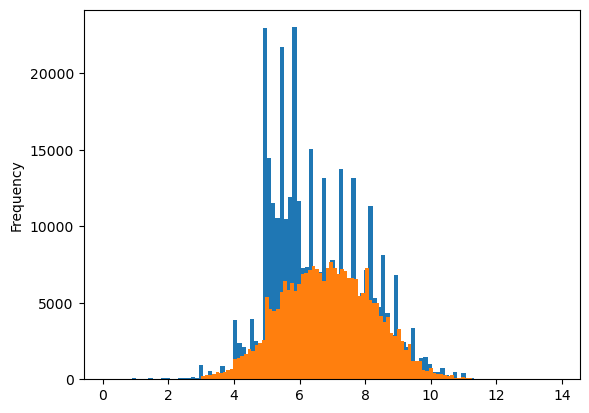

In [159]:
# simple visualization
data_curated[data_curated['Activity_Type']=='pKi']['Activity_Value'].plot.hist(bins=100)
dataset_curated[dataset_curated['Activity_Type']=='pKi']['Activity_Value'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

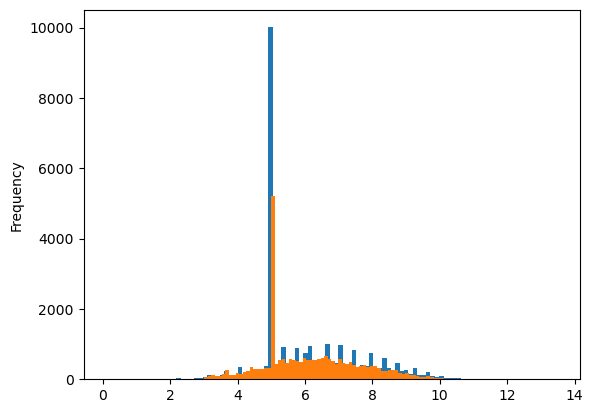

In [161]:
data_curated[data_curated['Activity_Type']=='pKd']['Activity_Value'].plot.hist(bins=100)
dataset_curated[dataset_curated['Activity_Type']=='pKd']['Activity_Value'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

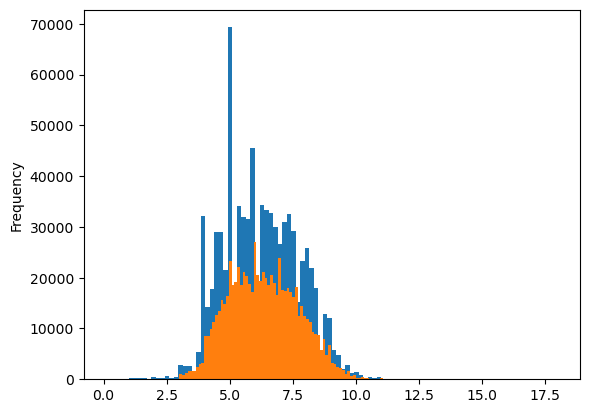

In [162]:
data_curated[data_curated['Activity_Type']=='pIC50']['Activity_Value'].plot.hist(bins=100)
dataset_curated[dataset_curated['Activity_Type']=='pIC50']['Activity_Value'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

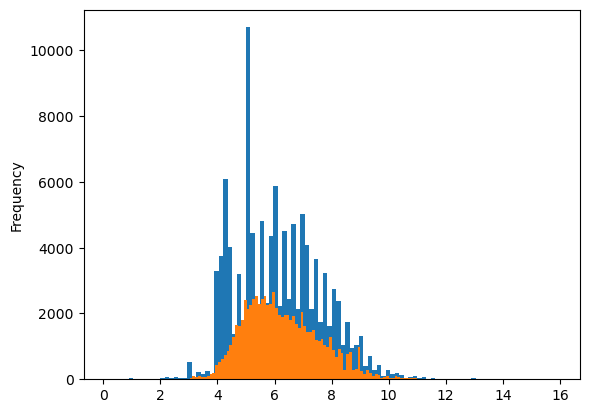

In [163]:
data_curated[data_curated['Activity_Type']=='pEC50']['Activity_Value'].plot.hist(bins=100)
dataset_curated[dataset_curated['Activity_Type']=='pEC50']['Activity_Value'].plot.hist(bins=100)

In [9]:
# integrate data
data_curated['Source_2'] = 'EquiVS'
dataset_curated['Source_2'] = 'Papyrus'

integrated_data = pd.concat([data_curated, dataset_curated], axis=0)
integrated_data.to_csv('Integrated_dataset/integrated_data.csv', index=False)

In [10]:
# save smiles dictionary
import pickle

def save_dict(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_dict(dict(zip(smiles_list['After'], smiles_list.index)), 'Integrated_dataset/smiles_dict')

In [14]:
integrated_data[integrated_data['Activity_Type'] == 'pIC50']['SMILES'].value_counts()

SMILES
CN1C(=O)C(N2CCc3cn(CC4CCS(=O)(=O)CC4)nc3C2=O)COc2ccccc21                          319
CN1C(=O)C(N2CCc3c(nn(Cc4ccccc4)c3Br)C2=O)COc2ccccc21                              276
CN1C(=O)C(N2CCc3cn(Cc4ccccc4)nc3C2=O)COc2ccccc21                                  276
CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4    257
O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12                                        216
                                                                                 ... 
Cc1ccc2[se]n(CCCCn3[se]c4ccc(C)cc4c3=O)c(=O)c2c1                                    1
CC(C)(Oc1ccc(-n2cccn2)cn1)C(=O)N[C@H]1C2CC3CC1C[C@](C(N)=O)(C3)C2                   1
CC(C)(Oc1ccc(Cl)cc1)C(=O)N[C@H]1C2CC3CC1C[C@](CC(=O)O)(C3)C2                        1
CC(C)(Oc1ccc(Cl)cc1)C(=O)N[C@H]1C2CC3CC1C[C@](CCC(=O)O)(C3)C2                       1
COc1ccc(C(=O)c2c(C)n(CCN3CCOCC3)c3cc(C)ccc23)cc1                                    1
Name: count, Length: 676824, dtype: int64

In [3]:
os.chdir('../Activity-cliff-prediction/')

In [8]:
kd = pd.read_csv('data/kd.csv')
kd['type'] = 'kd'
ki = pd.read_csv('data/ki.csv')
ki['type'] = 'ki'
ic50 = pd.read_csv('data/ic50.csv')
ic50['type'] = 'ic50'
ec50 = pd.read_csv('data/ec50.csv')
ec50['type'] = 'ec50'

In [9]:
df = pd.concat([kd, ki, ic50, ec50], axis=0)
df.to_csv('data/integrated.csv', index=False)

In [4]:
ep = 'ki'
df = pd.read_csv(f'data/MolACE_CPI_{ep}.csv')
df['split'] = 'test'
df.to_csv(f'data/MolACE_CPI_{ep}_alltest.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'MolACE_CPI_ki.csv'

In [5]:
os.chdir('/scratch/yg3191/Activity-cliff-prediction/data')
ki = pd.read_csv('ki.csv')
ki['type'] = 'ki'
ic50 = pd.read_csv('ic50.csv')
ic50['type'] = 'ic50'
ec50 = pd.read_csv('ec50.csv')
ec50['type'] = 'ec50'
kd = pd.read_csv('kd.csv')
kd['type'] = 'kd'

combine = pd.concat([ki, ic50, ec50, kd], axis=0)
combine_train = combine[combine['split'] == 'train']
combine_test = combine[combine['split'] == 'test']
duplicate = combine_train[combine_train.duplicated(subset=['smiles', 'Uniprot_id'], keep=False)]
non_duplicate = combine_train[~combine_train.duplicated(subset=['smiles', 'Uniprot_id'], keep=False)]

In [7]:
def process_duplicate_df(df):
    result = []
    for group in tqdm(df.groupby(['Uniprot_id', 'smiles'])):
        if 'ki' in group[1]['type'].values or 'kd' in group[1]['type'].values:
            group[1]['y'] = group[1][group[1]['type'].isin(['ki', 'kd'])]['y'].mean()
            result.append(group[1].iloc[0, :].values)
        else:
            group[1]['y'] = group[1][group[1]['type'].isin(['ic50', 'ec50'])]['y'].mean()
            result.append(group[1].iloc[0, :].values)
    df = pd.DataFrame(result, columns=df.columns)
    return df

print('Number of duplicate data:', len(duplicate))
duplicate = process_duplicate_df(duplicate)
print('Number of duplicate data after processing:', len(duplicate))

Number of duplicate data: 44109


100%|██████████| 21827/21827 [00:17<00:00, 1282.70it/s]


Number of duplicate data after processing: 21827


<Axes: ylabel='Frequency'>

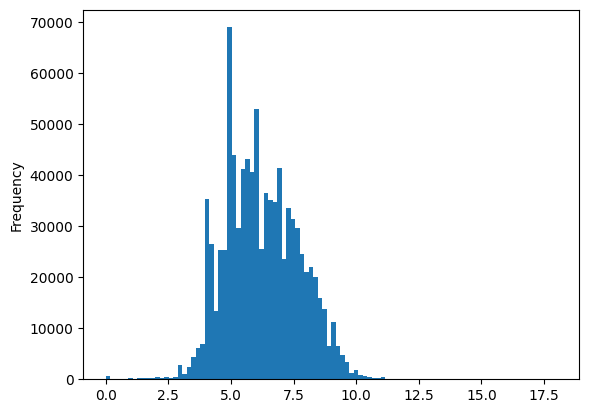

In [8]:
combine = pd.concat([non_duplicate, duplicate, combine_test], axis=0)
combine.to_csv('integrated.csv', index=False)

In [2]:
os.chdir('../Activity-cliff-prediction/')
df = pd.read_csv('data/ki.csv')
df

,smiles,exp_mean [nM],y,cliff_mol,split,Uniprot_id,Sequence
0,CC(C)CN(Cc1cc(Cl)c2c(c1)OCCCO2)C(=O)CCC1CCCN1,10000.000000,5.00,0,test,G3H407,MPPAGINMASQNKNTSFAPDLNPSQDHISSLPFNFSYSDYDLPLDG...
1,CC(C)CN(Cc1cc(Cl)c2c(c1)OCCCO2)C(=O)C1CCN(Cc2c...,7.244360,8.14,1,train,G3H407,MPPAGINMASQNKNTSFAPDLNPSQDHISSLPFNFSYSDYDLPLDG...
2,CC(C)CN(Cc1cc(Cl)c2c(c1)CCCCO2)C(=O)C1CCN(Cc2c...,11.220185,7.95,1,train,G3H407,MPPAGINMASQNKNTSFAPDLNPSQDHISSLPFNFSYSDYDLPLDG...
3,CC(C)CN(Cc1cc(Cl)c2c(c1)OCCCO2)C(=O)C1CN(Cc2cc...,14.125375,7.85,0,train,G3H407,MPPAGINMASQNKNTSFAPDLNPSQDHISSLPFNFSYSDYDLPLDG...
4,CC(C)CN(Cc1ccc2c(c1)OCCCO2)C(=O)C1CN(Cc2ccccc2...,588.843655,6.23,0,train,G3H407,MPPAGINMASQNKNTSFAPDLNPSQDHISSLPFNFSYSDYDLPLDG...
...,...,...,...,...,...,...,...
341239,Cc1cc(C(=O)NC(Cc2ccccc2)C(O)CNC(C(=O)NCC(C)C)C...,1.000000,9.00,0,train,Q9Y5Z0,MGALARALLLPLLAQWLLRAAPELAPAPFTLPLRVAAATNRVVAPT...
341240,Cc1ncsc1CN(C(=O)CCC(C1CCCCC1)N1Cc2cc(Oc3ccccc3...,50.118723,7.30,0,train,Q9Y5Z0,MGALARALLLPLLAQWLLRAAPELAPAPFTLPLRVAAATNRVVAPT...
341241,Cc1oncc1CN(C(=O)CCC(C1CCCCC1)N1Cc2cc(Oc3ccccc3...,63.095734,7.20,0,train,Q9Y5Z0,MGALARALLLPLLAQWLLRAAPELAPAPFTLPLRVAAATNRVVAPT...
341242,NC1=Nc2ccc(Oc3ccccc3)cc2CN1C(CCC(=O)N(CC1CCC(=...,50.118723,7.30,0,train,Q9Y5Z0,MGALARALLLPLLAQWLLRAAPELAPAPFTLPLRVAAATNRVVAPT...


In [3]:
df2 = pd.read_csv('data/MolACE_CPI_ki.csv')

In [5]:
df['combine'] = df['smiles'] + df['Uniprot_id']
df2['combine'] = df2['smiles'] + df2['Uniprot_id']

KeyError: 'SMILES'